Выполнил: Распеченко Станислав

t.me/stanispar

# Построение модели классификации для оптимизации заявок по поиску репетитора

**Описание проекта:**
Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%. 
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.


**Цель проекта:**
Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC. 


**Описание данных:** 

Три датасета:

orders - данные о конкретной заявке (дата создания, предмет, цель занятий, желаемая продолжительность, и т.д.)

suitable_teachers - подходящие для данной заявки репетиторы (id репетитора, id заявки, доступен ли репетитор к работе, и т.д.)

teacher_info - информация обо всех имеющихся в базе репетиторах (дата регистрации, дата начала преподавания, дата рождения, и т.д.)

**План работы:**

1 ПРЕДОБРАБОТКА ДАННЫХ

1.1 Импорт библиотек

1.2 Загрузка датасетов, вывод первичной информации

1.3 Промежуточные выводы

1.4 Предобработка данных

1.4.1 Предобработка и объединение датасетов suitable_teachers и teachers_info

1.4.2 Объединение датасетов orders и teachers в рабочий датасет и его последующая обработка

1.5 Вывод

2 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

2.1 Матрица фи-корреляции

2.2 Вывод

3 ПОДГОТОВКА К ОБУЧЕНИЮ МОДЕЛЕЙ

3.1 Разбивка датасета на выборки

3.2 Выделение признаков и целевого признака

3.3 Масштабирование числовых признаков

3.4 Вывод

4 Обучение моделей

4.1 LGBM

4.2 CatBoost

4.3 RandomForest

4.4 LogisticRegression

4.5 LGBM с масштабированными признаками

4.6 Вывод

5 БОРЬБА С ДИСБАЛАНСОМ

5.1 Балансировка

5.1.1 LGBM

5.1.2 CatBoost

5.1.3 RandomForest

5.1.4 LogisticRegression

5.2 Увеличение выборки

5.2.1 Функция для увеличения выборки

5.2.2 LGBM

5.2.3 CatBoost

5.2.4 CatBoost с применением GridSearchCV

5.2.5 RandomForest

5.2.6 LogisticRegression

5.3 Уменьшение выборки

5.3.1 Функция для уменьшения выборки

5.3.2 LGBM

5.3.3 CatBoost

5.3.4 RandomForest

5.3.5 LogisticRegression

5.4 Вывод

6 ПРОВЕРКА МОДЕЛИ

6.1 Проверка модели на тестовой выборке

6.2 Вывод

7 ОБЩИЙ ВЫВОД

## Предобработка данных

### Импортируем необходимые библиотеки

In [1]:
#!pip install pyarrow

In [16]:
#!pip install phik

  Obtaining dependency information for phik from https://files.pythonhosted.org/packages/95/e3/250ce99ed761389028543fcb876176ba619f6bf387d6cce3bab736bd92cc/phik-0.12.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/667.1 kB ? eta -:--:--
   ------ --------------------------------- 112.6/667.1 kB 3.3 MB/s eta 0:00:01
   --------------------- ------------------ 358.4/667.1 kB 3.7 MB/s eta 0:00:01
   ---------------------------------- ----- 573.4/667.1 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 667.1/667.1 kB 3.5 MB/s eta 0:00:00


In [74]:
#!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.3 MB 5.1 MB/s eta 0:00:01
   ------- -------------------------------- 0.2/1.3 MB 2.4 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.3 MB 3.2 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.3 MB 3.5 MB/s eta 0:00:01
   --------------------------- ------------ 0.9/1.3 MB 3.4 MB/s eta 0:00:01
   ------------------------------------- -- 1.3/1.3 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 3.4 MB/s eta 0:00:00


In [50]:
#!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------- ----- 41.0/47.0 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 593.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.0 MB 1.1 MB/s eta 0:01:33
   ---------------------------------------- 0.1/101.0 MB 1.0 MB/s eta 0:01:38
   ---------------------------------------- 0.3/101.0 MB 1.8 MB/s eta 0:00:58
   ---------------------------------------- 0.5/101.0 MB 2.4 MB/s eta 0:00:42
   ---------------------------------------- 0.8/101.0 MB 2.7 MB/s eta 0:00:37
   ---------------------------------------- 1.1/101.0 MB 3.2 MB/s eta 0:00:31
    ---------------

In [57]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

### Загрузим датасеты в соответствующие переменные, выведем их и информацию о них на экран

In [2]:
DATA_PATH = 'C:/Users/ASUS/Documents/Projects/Repetit/datasets/'

In [4]:
suitable_teachers = pd.read_feather(os.path.join(DATA_PATH, 'suitable_teachers.feather'))
suitable_teachers.head()

teacher_id  order_id                                     contact_result  \
0       82583   1742711                               Репетитор согласился   
1      125057   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
2      231211   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
3      128773   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
4       63019   1742713                               Репетитор согласился   

   enable_auto_assign  enable_assign  
0                   1              1  
1                   0              0  
2                   0              0  
3                   0              0  
4                   0              1

In [6]:
teachers_info = pd.read_feather(os.path.join(DATA_PATH, 'teachers_info.feather'))
teachers_info.head()

id              date_update                 reg_date  \
0  33  2023-11-07 14:20:28.323  2007-12-24 19:26:46.000   
1  46  2023-01-19 17:36:42.233  2007-12-24 19:26:46.000   
2  51  2023-05-25 09:04:45.243  2007-12-24 19:26:46.000   
3  52  2023-01-19 10:39:20.767  2007-12-24 19:26:46.000   
4  54  2023-01-19 16:28:36.517  2007-12-24 19:26:46.000   

                birth_date      teaching_start_date  user_id  \
0  1983-06-05 00:00:00.000  1989-09-01 00:00:00.000       45   
1  1980-02-12 00:00:00.000  2003-09-01 00:00:00.000       63   
2  1965-04-30 00:00:00.000  1988-09-01 00:00:00.000       68   
3  1988-07-06 00:00:00.000  2006-09-01 00:00:00.000       69   
4  1985-09-30 00:00:00.000  2004-01-01 00:00:00.000       70   

   is_email_confirmed  is_home_lessons  is_external_lessons  \
0                   0                0                    0   
1                   0                1                    1   
2                   0                0                    0   
3                   0                0                    1   
4                   0                0                    1   

                          external_comments  ...  verification_status_id  \
0                                       NaN  ...                       1   
1                                       NaN  ...                       1   
2                                       NaN  ...                       3   
3           Ближайший район: м. Алтуфьево.   ...                       1   
4  Выезд в удобное для Вас время по Москве.  ...                       1   

   is_individual  partner_id star_rating  rating_for_users_yesterday  \
0            NaN         NaN    4.500000                      1138.0   
1            NaN         NaN    4.300781                        25.0   
2            0.0         NaN    4.300781                       300.0   
3            0.0         NaN    5.000000                       135.0   
4            NaN         NaN    4.300781                        50.0   

   review_num           relevance_date  is_display_at_partners  \
0           6  2022-05-16 18:44:59.993                       0   
1           0  2017-01-01 00:00:00.000                       1   
2           0  2017-01-01 00:00:00.000                       0   
3           2  2020-04-01 01:07:44.157                       1   
4           0  2017-01-01 00:00:00.000                       1   

   status_institution_id free_time_relevance_date  
0                 3702.0  2023-11-06 14:20:15.173  
1                    NaN                      NaN  
2                    NaN                      NaN  
3                    NaN                      NaN  
4                    NaN                      NaN  

[5 rows x 80 columns]

In [7]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

Датасет teachers_info содержит 307972 строки и 80 столбцов; имеются пропуски в данных.

In [87]:
orders = pd.read_feather(os.path.join(DATA_PATH, 'orders.feather'))
orders.head()

id               order_date  subject_id  \
0  2294054  2022-11-01 00:01:38.237         1.0   
1  2294055  2022-11-01 00:03:11.753         1.0   
2  2294056  2022-11-01 00:04:01.563        21.0   
3  2294057  2022-11-01 00:08:47.237         8.0   
4  2294058  2022-11-01 00:11:49.417         8.0   

                                             purpose  lesson_price  \
0                                               None             0   
1                                               None             0   
2  Разделы: начертательная геометрия.\nКатегория ...           800   
3  Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                               None             0   

   lesson_duration lesson_place  home_metro_id  \
0               60         None            NaN   
1               60         None            NaN   
2               60         None            NaN   
3               60         None            NaN   
4               60         None          122.0   

                                            add_info               start_date  \
0                                               None                     None   
1                                               None                     None   
2  Место проведения занятий: дистанционно (наприм...  2022-11-01 10:37:02.567   
3  Место проведения занятий: дистанционно (наприм...  2022-11-01 00:08:47.437   
4                                               None                     None   

   ...  chosen_teachers_only  no_teachers_available source_id  \
0  ...                     0                      0        18   
1  ...                     0                      0        18   
2  ...                     0                      0        23   
3  ...                     0                      0        14   
4  ...                     0                      0        16   

   original_order_id client_id  additional_status_id max_metro_distance  \
0          2294000.0    675960                   7.0                NaN   
1          2294000.0    675960                   7.0                NaN   
2                NaN   1024439                  10.0                NaN   
3          2293804.0   1024340                  17.0                NaN   
4                NaN   1024440                   5.0                NaN   

   estimated_fee  payment_date  is_display_to_teachers  
0           None          None                       1  
1           None          None                       1  
2           1200          None                       1  
3           2310          None                       1  
4           None          None                       1  

[5 rows x 38 columns]

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

Датасет orders содержит 1191861 строк и 38 столбцов; имеются пропуски в данных.

**Вывод:** Все три датасета содержат пропуски в данных. Для дальнейшего выполнения задачи проекта необходимо объединить их в один рабочий датасет и избавиться от пропусков.

### Предобработка данных

#### Предобработка и объединение датасетов suitable_teachers и teachers_info

Удалим из teachers_info столбцы, задублировавшиеся во время выгрузки и выведем информацию об обновленном датасете на экран:

In [8]:
teachers_info = teachers_info.drop(['external_comments.1', 'lesson_duration.1', 'lesson_cost.1', 
                                    'status_id.1', 'status_relevant_date.1', 'status_school_id.1', 
                                    'status_college_id.1', 'status_display.1', 'russian_level_id.1', 
                                    'home_country_id.1', 'information.1', 'is_confirmed.1', 
                                    'external_comments.2', 'lesson_duration.2', 'lesson_cost.2', 
                                    'status_id.2', 'status_relevant_date.2', 'status_school_id.2', 
                                    'status_college_id.2', 'status_display.2', 'russian_level_id.2', 
                                    'home_country_id.2', 'information.2', 'is_confirmed.2'], axis=1)
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

Отсортируем содержимое столбца teacher_id датасета suitable_teachers:

In [5]:
suitable_teachers['teacher_id'].sort_values()

5745859         33
14250262        33
540522          33
12902332        33
12070726        33
             ...  
20267394    312609
20250024    312609
20255497    312613
20212432    312623
20266345    312661
Name: teacher_id, Length: 20271186, dtype: int32

И содержимое столбца id датасета teachers_info:

In [7]:
teachers_info['id'].sort_values()

0             33
1             46
2             51
3             52
4             54
           ...  
307967    312618
307968    312619
307969    312620
307970    312621
307971    312622
Name: id, Length: 307972, dtype: int32

Оба этих столбца содержат информацию с уникальным id репетиторов. Поэтому по ним можно произвести объединение двух датасетов в один. Назовем его teachers:

In [ ]:
# Объединяем по принципу left, чтобы сохранить только айди из датасета suitable_teachers:
teachers = suitable_teachers.merge(teachers_info, left_on='teacher_id', right_on='id', how='left')
teachers.head()

Выведем информацию о получившемся датасете на экран:

In [10]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 61 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int32   
 1   order_id                    int32   
 2   contact_result              category
 3   enable_auto_assign          int8    
 4   enable_assign               int8    
 5   id                          float64 
 6   date_update                 category
 7   reg_date                    category
 8   birth_date                  category
 9   teaching_start_date         category
 10  user_id                     float64 
 11  is_email_confirmed          float64 
 12  is_home_lessons             float64 
 13  is_external_lessons         float64 
 14  external_comments           category
 15  lesson_duration             float64 
 16  lesson_cost                 float64 
 17  status_id                   float64 
 18  status_relevant_date        category
 19

Применив методы info(), unique(), sort_values() и value_counts(), изучим содержимое столбцов датасета teachers:

In [12]:
teachers['id'].sort_values()

5745859         33.0
14250262        33.0
540522          33.0
12902332        33.0
12070726        33.0
              ...   
20267394    312609.0
20250024    312609.0
20255497    312613.0
20212432         NaN
20266345         NaN
Name: id, Length: 20271186, dtype: float64

In [13]:
teachers['teacher_id'].sort_values()

5745859         33
14250262        33
540522          33
12902332        33
12070726        33
             ...  
20267394    312609
20250024    312609
20255497    312613
20212432    312623
20266345    312661
Name: teacher_id, Length: 20271186, dtype: int32

In [5]:
teachers['order_id'].value_counts()

order_id
2703618    478
2703890    477
2928494    476
2917035    437
2901487    433
          ... 
2458501      1
1979585      1
2342115      1
2457814      1
1742711      1
Name: count, Length: 842019, dtype: int64

In [7]:
teachers['contact_result'].unique()

['Репетитор согласился', 'Репетитор положил трубку, либо обрыв связи (O..., ',', NaN, 'Не дозвонились (Oktell)', ..., 'Богородский', '23 екат', 'Репетитор согласился с дополнительными услови..., 'Репетитор согласился с дополнительными услови..., 'к ученику?']
Length: 10867
Categories (10866, object): ['\nРепетитор оставил запрос : ', '\nРепетитор оставил запрос : \nРепетитор оста..., '\nРепетитор оставил запрос : Договорились о з..., '\nРепетитор оставил запрос : О занятии догово..., ..., '№', '№1 анкета понравилась, кл пока не хочет конта..., '№2 анкета не понравилась', '№3 анкета отправлена,  кл еще не смотрела']

In [65]:
teachers['date_update'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: date_update
Non-Null Count     Dtype   
--------------     -----   
20271184 non-null  category
dtypes: category(1)
memory usage: 87.7 MB


In [14]:
teachers['date_update'].sort_values()

5101546     2021-11-07 09:01:49.563
14482213    2021-11-07 09:01:49.563
15825485    2021-11-07 09:01:49.563
2754620     2021-11-07 09:01:49.563
958294      2021-11-07 09:01:49.563
                     ...           
14394529    2023-11-07 14:40:59.987
9101738     2023-11-07 14:40:59.987
18956301    2023-11-07 14:40:59.987
20212432                        NaN
20266345                        NaN
Name: date_update, Length: 20271186, dtype: category
Categories (307079, object): ['2020-11-05 13:52:08.960', '2021-11-06 22:52:20.260', '2021-11-07 09:01:49.563', '2021-11-11 15:27:51.903', ..., '2023-11-07 14:40:57.440', '2023-11-07 14:40:58.357', '2023-11-07 14:40:58.610', '2023-11-07 14:40:59.987']

In [63]:
teachers['enable_auto_assign'].unique()

array([1, 0], dtype=int8)

In [64]:
teachers['enable_assign'].unique()

array([1, 0], dtype=int8)

In [30]:
teachers['is_email_confirmed'].unique()

array([ 0.,  1., nan])

Предположим, что, в случае, если столбец is_email_confirmed не заполнен, email не был подтвержден, и заполним пропуски нулем:

In [35]:
teachers['is_email_confirmed'] = teachers['is_email_confirmed'].fillna(0)

In [4]:
teachers['is_email_confirmed'].unique()

array([0., 1.])

In [37]:
teachers['is_home_lessons'].unique()

array([ 1.,  0., nan])

Предположим, что, в случае, если столбец is_home_lessons не заполнен, заказчик по умолчанию готов заниматься дома, и заполним пропуски единицей:

In [38]:
teachers['is_home_lessons'] = teachers['is_home_lessons'].fillna(1)

In [5]:
teachers['is_home_lessons'].unique()

array([1., 0.])

In [6]:
teachers['is_external_lessons'].unique()

array([0., 1.])

In [41]:
teachers['is_external_lessons'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271186 entries, 0 to 20271185
Series name: is_external_lessons
Non-Null Count     Dtype  
--------------     -----  
20271184 non-null  float64
dtypes: float64(1)
memory usage: 154.7 MB


Проверим, являются ли значения столбцов is_home_lessons и is_external_lessons взаимоисключающими:

In [4]:
teachers[['is_home_lessons', 'is_external_lessons']]

is_home_lessons  is_external_lessons
0                     1.0                  0.0
1                     0.0                  1.0
2                     0.0                  1.0
3                     0.0                  1.0
4                     1.0                  1.0
...                   ...                  ...
20271181              0.0                  1.0
20271182              1.0                  1.0
20271183              0.0                  1.0
20271184              1.0                  1.0
20271185              0.0                  1.0

[20271186 rows x 2 columns]

Прямой зависимости между двумя столбцами не обнаружено.

Предположим, что, в случае, если столбец is_external_lessons не заполнен, заказчик по умолчанию готов заниматься вне дома, и заполним пропуски единицей:

In [21]:
teachers['is_external_lessons'] = teachers['is_external_lessons'].fillna(1)

In [22]:
teachers['is_external_lessons'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271186 entries, 0 to 20271185
Series name: is_external_lessons
Non-Null Count     Dtype  
--------------     -----  
20271186 non-null  float64
dtypes: float64(1)
memory usage: 154.7 MB


In [42]:
teachers['external_comments'].unique()

[NaN, 'Ближайший район: м. Царицыно. Выезд: Восточно..., 'Ближайший район: м. Царицыно. ', 'Ближайший район: м. Царицыно. Выезд: в предел..., 'Ближайший район: м. Кузьминки. ', ..., 'Ближайший район: г. Химки. Выезд: СЗАО, САО.', 'Ближайший район: Промышленный округ. ', 'Адмиралтейский, Центральный, Василеостровский..., 'Ближайший район: м. Ломоносовский проспект. В..., 'Ближайший район: м. Медведково. Выезд: СВАО, ...]
Length: 7602
Categories (26082, object): ['\r\n', '\r\n\r\n\r\n', ' ', '   Могу выезжать к ученикам по серой ветке мо..., ..., 'южное, северное бутово, метро аннино - южная', 'южный округ', 'юзао, зао', 'ясенево, теплый стан, коньково, беляево, калу...]

In [43]:
teachers['external_comments']

0                                                         NaN
1           Ближайший район: м. Царицыно. Выезд: Восточное...
2                              Ближайший район: м. Царицыно. 
3           Ближайший район: м. Царицыно. Выезд: в предела...
4                                                         NaN
                                  ...                        
20271181         Ближайший район: м. Ломоносовский проспект. 
20271182                                                  NaN
20271183                        Ближайший район: д. Кудрово. 
20271184                                                  NaN
20271185    Ближайший район: м. Московская. Выезд: районы ...
Name: external_comments, Length: 20271186, dtype: category
Categories (26082, object): ['\r\n', '\r\n\r\n\r\n', ' ', '   Могу выезжать к ученикам по серой ветке мо..., ..., 'южное, северное бутово, метро аннино - южная', 'южный округ', 'юзао, зао', 'ясенево, теплый стан, коньково, беляево, калу...]

In [7]:
teachers['lesson_duration'].unique()

array([ 45.,  60., 120.,  90.,  40.,  30.,  50.,  80.,  55.,  70., 180.,
        75., 150., 100.,  35.,  42., 135., 240., 105., 130.,  48., 110.,
        65.,  68.,  34.,  25.,  20.,  85., 360., 160.,  33.,  95.])

Заменим пропуски в столбце lesson_duration медианным значением:

In [6]:
teachers['lesson_duration'] = teachers['lesson_duration'].fillna(teachers['lesson_duration'].median())

In [7]:
teachers['lesson_duration'].unique()

array([ 45.,  60., 120.,  90.,  40.,  30.,  50.,  80.,  55.,  70., 180.,
        75., 150., 100.,  35.,  42., 135., 240., 105., 130.,  48., 110.,
        65.,  68.,  34.,  25.,  20.,  85., 360., 160.,  33.,  95.])

In [8]:
teachers['lesson_cost'].unique()

array([6.0000e+02, 1.0000e+03, 7.0000e+02, 2.5000e+03, 0.0000e+00,
       7.5000e+02, 1.2000e+03, 2.0000e+03, 1.1000e+03, 8.0000e+02,
       5.0000e+02, 9.0000e+02, 1.5000e+03, 1.2500e+03, 4.0000e+02,
       1.3000e+03, 3.5000e+02, 5.5000e+02, 3.0000e+02, 1.8000e+03,
       3.0000e+03, 1.9000e+03, 1.6670e+03, 1.6000e+03, 4.0000e+03,
       1.4000e+03, 1.4990e+03, 4.5000e+02, 1.3500e+03, 2.5000e+02,
       2.1000e+03, 1.7000e+03, 3.5000e+03, 6.5000e+02, 2.2500e+03,
       9.5000e+02, 3.6000e+03, 8.5000e+02, 2.8000e+03, 1.8500e+03,
       5.5000e+03, 2.7000e+03, 6.0000e+03, 4.5000e+03, 1.4500e+03,
       5.0000e+03, 1.7500e+03, 1.1250e+03, 2.2000e+03, 1.1500e+03,
       2.9000e+03, 4.8000e+02, 3.8000e+02, 2.0000e+02, 4.2000e+03,
       6.7500e+02, 7.0000e+03, 1.6500e+03, 2.3000e+03, 2.6250e+03,
       4.0500e+03, 2.4000e+03, 3.7000e+03, 1.9500e+03, 3.2000e+03,
       9.8000e+02, 1.0500e+03, 2.3500e+03, 6.2500e+02, 1.2800e+03,
       2.5500e+03, 8.8400e+02, 6.7000e+02, 7.5000e+03, 9.9000e

Заменим пропуски в столбце lesson_cost медианным значением:

In [9]:
teachers['lesson_cost'] = teachers['lesson_cost'].fillna(teachers['lesson_cost'].median())

In [9]:
teachers['status_id'].unique()

array([3., 1., 5., 4., 7., 2.])

In [8]:
teachers['status_relevant_date'].unique()

[NaN, '2022-06-01 00:00:00.000', '2026-06-01 00:00:00.000', '2019-06-01 00:00:00.000', '2024-06-01 00:00:00.000', ..., '2023-06-27 20:00:00.000', '2021-12-26 00:00:00.000', '2022-08-09 00:00:00.000', '2024-11-23 00:00:00.000', '2028-12-01 00:00:00.000']
Length: 1203
Categories (1575, object): ['2000-02-01 00:00:00.000', '2000-06-01 00:00:00.000', '2000-07-01 00:00:00.000', '2000-11-01 00:00:00.000', ..., '9000-06-01 00:00:00.000', '9000-09-01 00:00:00.000', '9000-11-01 00:00:00.000', '9900-09-01 00:00:00.000']

In [9]:
teachers['status_relevant_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: status_relevant_date
Non-Null Count    Dtype   
--------------    -----   
2556819 non-null  category
dtypes: category(1)
memory usage: 38.7 MB


In [16]:
teachers['status_school_id'].unique()

array([4028.,   nan, 3084., ..., 1065.,  619.,  441.], dtype=float16)

In [23]:
teachers['status_school_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271186 entries, 0 to 20271185
Series name: status_school_id
Non-Null Count    Dtype  
--------------    -----  
2143059 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [17]:
teachers['status_college_id'].unique()

array([  nan,  777.,  798.,  772.,  815.,  874.,  781., 2034.,  602.,
        783.,  765., 1747., 1751., 2788., 1244., 1241.,  780., 1191.,
       1996.,  214.,  785., 2011.,  278., 2012., 1935., 1664.,   64.,
        731., 2472.,  585., 1276.,  726.,  715., 1780., 2017.,  792.,
        776., 1183.,  876.,  738.,   65., 1043.,  896.,  773., 2008.,
       1985.,  747.,  761.,  733.,  810., 1315.,  835.,  105., 2916.,
       2068., 2002., 1587.,   85.,  688.,  774.,    5., 3082.,  728.,
        786.,  734., 2638.,  213., 2384.,  920., 1083., 2156., 1989.,
        306.,  501., 2072., 1343.,  691.,  784.,  428., 1247., 1252.,
       2038., 2932.,  809.,  735.,  764., 2798., 3012.,  967., 1851.,
        632.,  740., 1853.,  793., 2842.,  752.,  742., 2007.,  770.,
        350.,  498.,  814.,  960., 3008.,  348.,  897., 1278., 2884.,
       2016.,  154., 2476.,  756., 2004.,  902., 2018., 1192., 1855.,
       2288.,  690.,  805., 2014.,  647.,  803.,  711.,  763., 2500.,
        633., 1282.,

In [19]:
teachers['status_college_id'].count()

884182

In [20]:
teachers['status_college_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271186 entries, 0 to 20271185
Series name: status_college_id
Non-Null Count   Dtype  
--------------   -----  
884182 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [6]:
teachers['status_display'].info()

<class 'pandas.core.series.Series'>
Index: 20271184 entries, 0 to 20271185
Series name: status_display
Non-Null Count     Dtype  
--------------     -----  
20271184 non-null  float64
dtypes: float64(1)
memory usage: 309.3 MB


Удалим из датасета teachers строки с пропусками в столбце status_display:

In [4]:
teachers = teachers.dropna(subset=['status_display'], ignore_index=True)

In [10]:
teachers['status_display'].unique()

array([0., 1.])

Выведем информацию об обновленном датасете:

In [27]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 61 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int32   
 1   order_id                    int32   
 2   contact_result              category
 3   enable_auto_assign          int8    
 4   enable_assign               int8    
 5   id                          float64 
 6   date_update                 category
 7   reg_date                    category
 8   birth_date                  category
 9   teaching_start_date         category
 10  user_id                     float64 
 11  is_email_confirmed          float64 
 12  is_home_lessons             float64 
 13  is_external_lessons         float64 
 14  external_comments           category
 15  lesson_duration             float64 
 16  lesson_cost                 float64 
 17  status_id                   float64 
 18  status_relevant_date        category
 19

In [11]:
teachers['russian_level_id'].unique()

array([5., 1., 2., 4., 3., 0.])

In [12]:
teachers['home_country_id'].unique()

array([  7.,  45.,  10.,  68.,  43.,  34.,  56.,  17.,  47.,  44.,  11.,
        41.,   6.,   9., 138.,   4.,   2.,  58.,  72.,  48.,  19.,  13.,
        50.,  82., 187.,  29.,  38.,  51.,   1.,  64.,  21.,  23.,  73.,
       139.,  31.,  36., 179.,  77.,  65.,   3., 113.,  26.,  14.,   8.,
       218., 201., 208.,  12.,  35.,  98.,  33., 150.,  61.,  15.,  37.,
        78.,  24., 193.,  18.,  40.,  91.,  76.,  80.,  39.,  93., 175.,
        52.,  27., 210.,  84.,  55.,  60., 220.,  20., 101.,  46.,  30.,
        25.,  88.,  67., 147., 221., 133.,   5.,  86.,  16., 223.,  53.,
        85., 123., 114., 115., 224., 124.,  92.,  74., 219., 213.,  63.,
       126.,  90., 154., 189.,  66., 185.,  59.,  22.,  57.,  32.,  83.,
        75., 107.,  70.,  71.,  69., 216., 106.,  28., 142., 164.,  81.,
       165.,  79., 197.,  89., 148.,  49., 160., 103., 131., 155., 151.,
       181., 212., 200.,  87., 116., 209., 163.,  62.])

In [13]:
teachers['information'].unique()

['[p]Лауреат всероссийских и международных конк..., NaN, '[p]Здравствуйте! Меня зовут Елизавета Налётов..., '[p]Добрый день.[/p][ul][li]Стаж репетитором &..., '[p]Учитель высшей категории. Руководитель РМО..., ..., '[p]Практикующий графический дизайнер. Более 5..., '[p]Люблю обучать, помогать разобраться, вдохн..., '[p]Добрый день! Я репетитор английского языка..., '[p]Специализируюсь на научно-академическом ан..., '[p]Окончила НГЛУ&nbsp;им. Добролюбова по напр...]
Length: 78186
Categories (121897, object): ['\tНоситель языка', '\n', '\n\n', '\n\n ', ..., '•\tПобедитель республиканских олимпиад по мат..., '•\tПреподавание студентам институтов  с 1 по ..., '•\tимею публикации по проблемам дополнительно..., '•2005-2006 гг. - курсы редких языков в МГИМО ...]

In [13]:
teachers['is_confirmed'].unique()

array([1., 0.])

In [14]:
teachers['is_display'].unique()

array([1., 0.])

In [15]:
teachers['rating_id'].unique()

array([15., 17., 16., 28., 10.,  2.,  6.,  8., 23.,  5., 14., 12., 22.,
        9.,  1.,  3., 21., 11.,  4.])

In [16]:
teachers['rating'].unique()

array([ 5.000e+00,  7.000e+00,  6.000e+00, -1.005e+05, -1.000e+01,
       -1.000e+00, -5.000e+00, -7.000e+00,  1.000e+01, -4.000e+00,
       -2.500e+01, -1.400e+01, -3.000e+01, -8.000e+00,  0.000e+00,
       -2.000e+00, -1.700e+01, -1.200e+01, -3.000e+00])

In [18]:
teachers['rules_confirmed_date'].unique()

['2014-08-12 00:00:00.000', '2017-10-01 20:39:02.000', '2021-05-05 13:53:21.797', '2014-11-11 00:24:30.000', '2021-08-20 09:25:40.647', ..., '2023-11-04 11:52:35.370', '2015-11-06 16:20:35.000', '2019-01-08 22:47:22.167', '2023-10-15 22:39:13.020', '2018-11-02 14:41:40.390']
Length: 126759
Categories (222686, object): ['2014-08-11 08:13:27.000', '2014-08-11 09:31:18.000', '2014-08-11 10:11:15.000', '2014-08-11 10:49:41.000', ..., '2023-11-07 13:49:38.663', '2023-11-07 14:20:23.607', '2023-11-07 14:22:37.887', '2023-11-07 14:32:36.847']

In [29]:
np.unique(teachers['last_visited'])

array(['2008-02-27T00:00:00.000000000', '2008-03-16T00:00:00.000000000',
       '2008-05-23T00:00:00.000000000', ...,
       '2022-10-23T00:00:00.000000000', '2022-10-24T00:00:00.000000000',
                                 'NaT'], dtype='datetime64[ns]')

In [20]:
teachers['is_pupils_needed'].unique()

array([nan,  1.,  0.], dtype=float16)

In [21]:
teachers['is_pupils_needed'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: is_pupils_needed
Non-Null Count   Dtype  
--------------   -----  
497571 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [23]:
teachers['is_cell_phone_confirmed'].unique()

array([0., 1.])

In [24]:
teachers['effective_rating'].unique()

array([   0.  ,    9.  ,  -35.66, ...,   20.55, -117.7 ,  -21.  ],
      dtype=float16)

In [25]:
teachers['area_id'].unique()

array([ 12.,   1.,  14.,  15.,  16.,   7.,  65.,   2.,  27.,   5.,   9.,
         6.,  19.,  31.,  50.,   8.,  45.,  17.,  40.,  42.,  11.,  13.,
         4.,   3.,  10.,  22.,  38.,  49.,  34.,  23.,  48.,  18.,  51.,
        21.,  25.,  36.,  29.,  46.,  41.,  30.,  24.,  43.,  58.,  44.,
        70.,  68.,  33.,  32.,  64.,  69.,  59.,  37., 119.,  56.,  20.,
        35.,  54.,  62.,  88.,  39.,  52.,  61.,  57.,  81.,  53.,  60.,
        55.,  77.,  66.,  76.,  79.,  67.,  63.,  82.,  84., 116.,  80.,
        47.,  85.,  91.,  87.,  78.,  90.,  86., 120., 117.,  89., 118.,
       121.,  83.])

In [26]:
teachers['pupil_needed_date'].unique()

[NaN, '2023-01-01 00:00:00.000', '2022-04-19 00:00:00.000', '2024-04-01 00:00:00.000', '2023-09-01 00:00:00.000', ..., '2027-10-24 00:00:00.000', '2028-11-03 00:00:00.000', '2014-10-01 00:00:00.000', '2021-04-27 00:00:00.000', '2019-09-17 00:00:00.000']
Length: 3221
Categories (4571, object): ['2009-12-06 00:00:00.000', '2010-01-01 00:00:00.000', '2010-03-10 00:00:00.000', '2010-04-15 00:00:00.000', ..., '5955-10-29 00:00:00.000', '7777-09-01 00:00:00.000', '9999-11-11 00:00:00.000', '9999-12-31 00:00:00.000']

In [27]:
teachers['pupil_needed_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: pupil_needed_date
Non-Null Count    Dtype   
--------------    -----   
4870423 non-null  category
dtypes: category(1)
memory usage: 38.8 MB


In [28]:
teachers['sex'].unique()

array([1., 2., 3.])

In [29]:
teachers['amount_to_pay'].unique()

array([  0., 500.])

In [30]:
teachers['is_remote_lessons'].unique()

array([0., 1.])

In [31]:
teachers['remote_comments'].unique()

[NaN, '%Возможны.%', 'Только удаленные занятия.', 'С предоплатой.', 'Возможны дистанционные занятия по Skype. Стои..., ..., 'Неограниченное консультирование по Skype и те..., '*****', 'Провожу занятия по Skype', 'Возможны. Стоимость занятий 350 рублей за 60 ..., 'Возможны дистанционные занятия по Skype. Стои...]
Length: 462
Categories (2602, object): ['\n', '\n\n', '\n\n\n', '\n\n\n\n\n5) Занятия у себя - загородный 64 к..., ..., 'эффективная авторская методика проведения зан..., 'эффективные занятия по скайпу', 'я могу ', '• преподавание английского языка школьникам, ...]

In [32]:
teachers['show_on_map'].unique()

array([1., 0.])

In [33]:
teachers['send_mailing'].unique()

array([1., 0.])

In [35]:
teachers['send_suitable_orders'].unique()

array([1., 0.])

In [36]:
teachers['rating_for_users'].unique()

array([ 150.,  330.,  200., ..., 3694., 3530., 4700.], dtype=float16)

In [37]:
teachers['rating_for_admin'].unique()

array([  0.  , 321.8 , 125.  , ...,  34.66,  50.34,  30.61], dtype=float16)

In [38]:
teachers['passport_id'].unique()

array([  nan,  901.,  637., ..., 1275.,   36., 1363.], dtype=float16)

In [39]:
teachers['passport_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: passport_id
Non-Null Count   Dtype  
--------------   -----  
485863 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [40]:
teachers['is_edited'].unique()

array([1., 0.])

In [41]:
teachers['orders_allowed'].unique()

array([1., 0.])

In [42]:
teachers['display_days'].unique()

array([3180. , 2232. ,  886. , ...,  284.5,   93.5,  148.5], dtype=float16)

In [43]:
teachers['verification_status_id'].unique()

array([0., 3., 1., 2., 4.])

In [44]:
teachers['is_individual'].unique()

array([ 0., nan,  1.], dtype=float16)

In [45]:
teachers['is_individual'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: is_individual
Non-Null Count    Dtype  
--------------    -----  
7416689 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [46]:
teachers['partner_id'].unique()

[NaN, 'ya_mow_own_sn_hv', 'ya_mow_own_sn_brand', 'ya_mow_own_dn_s-sd_top', 'ga_mow_own_sn_hv', ..., 'yandex.cpc.gbid-3946949849_.mow_sn_base-some_..., 'yandex.cpc.gbid-4155737481_.campid-50829729_...., 'yandex.cpc.gbid-3890210829_.spb_sn_base-some_..., 'google.cpc.mow_own_sn_rep_hv_conv-5_dmt_campi..., 'yandex.cpc.fld-some_phrase_part-2_gbid-331922...]
Length: 4294
Categories (6062, object): ['114653', '122347', '128221', '129966', ..., 'ydm.cpm.mow_cpm_1_', 'ydn.cpc.gbid-%7Bgbid%7D_.campid-54916333_.adi..., 'ydn.cpc.gbid-4297601883_.campid-54811006_.adi..., 'ydn.cpc.gbid-4299608929_.campid-54839357_.adi...]

In [47]:
teachers['star_rating'].unique()

array([4.3, 5. , 4.9, 4.8, 4.7, 4.6, 4.5, 4.1, 4.4, 2.2, 3.4, 3. , 2.9,
       3.8, 3.5, 4.2, 3.3, 4. , 3.6, 3.2, 3.9, 3.1, 2.4, 3.7, 2.8, 2.7,
       2.5, 0. ], dtype=float16)

In [48]:
teachers['rating_for_users_yesterday'].unique()

array([ 150.  ,  330.  ,  200.  , ...,   31.67, 3694.  , 4552.  ],
      dtype=float16)

In [49]:
teachers['review_num'].unique()

array([  0.,   4.,   1.,  12.,  58.,   3.,   2.,  19.,   8.,  34.,   6.,
        27.,  47.,  21.,  14.,  33.,  23.,  24.,   7.,   5.,  15.,   9.,
        20.,  38.,  18.,  40.,  43.,  17.,  11.,  13.,  10.,  25.,  56.,
        36., 121., 142.,  45.,  62.,  63.,  98.,  83.,  61.,  78., 189.,
        49., 127., 114., 132.,  16.,  54.,  52.,  65.,  31.,  29.,  41.,
        82.,  35.,  39.,  70.,  28.,  44.,  26.,  53.,  66.,  30.,  37.,
        86.,  22.,  51.,  67.,  42.,  64.,  57.,  90.,  80.,  32.,  46.,
        73.,  71.,  60., 106.,  76.,  50.,  48., 101.,  92., 152.,  87.,
        79.,  55.,  77., 102.,  72.,  69.,  74.,  85.,  93., 139.,  81.,
        59., 100., 119., 112.,  68., 193., 332., 124., 117.,  91., 126.,
        99., 381., 154.,  97.,  75., 120.,  88., 111.,  84.,  96., 159.,
       128., 122., 185., 116.,  89., 133.,  95.,  94.])

In [50]:
teachers['relevance_date'].unique()

['2017-01-01 00:00:00.000', '2017-10-01 20:31:58.000', '2021-05-05 13:53:21.797', '2017-09-17 18:35:35.000', '2023-07-20 18:38:42.217', ..., '2023-11-04 11:52:35.370', '2019-01-08 22:47:22.167', '2023-10-15 22:39:13.020', '2018-11-02 14:41:40.390', '2017-10-29 13:29:21.000']
Length: 127059
Categories (222907, object): ['2017-01-01 00:00:00.000', '2017-04-06 18:14:30.297', '2017-04-06 18:36:26.797', '2017-04-06 20:15:31.580', ..., '2023-11-07 14:16:33.770', '2023-11-07 14:20:23.607', '2023-11-07 14:22:37.887', '2023-11-07 14:32:36.847']

In [52]:
teachers['is_display_at_partners'].unique()

array([1., 0.])

In [53]:
teachers['status_institution_id'].unique()

array([7136.,   nan, 6192., ..., 7580., 7616.,  101.], dtype=float16)

In [54]:
teachers['status_institution_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: status_institution_id
Non-Null Count    Dtype  
--------------    -----  
3773974 non-null  float16
dtypes: float16(1)
memory usage: 38.7 MB


In [55]:
teachers['free_time_relevance_date'].unique()

[NaN, '2023-10-17 23:54:39.057', '2023-10-23 08:53:54.300', '2023-11-01 18:01:26.580', '2023-11-04 20:09:24.843', ..., '2023-11-05 13:23:44.987', '2023-10-30 15:59:01.330', '2023-09-13 19:03:39.287', '2023-11-02 14:01:43.510', '2023-11-04 12:19:08.357']
Length: 1621
Categories (1705, object): ['2021-10-23 13:04:52.410', '2021-10-23 14:07:08.050', '2021-10-24 11:42:25.860', '2021-10-24 15:29:19.083', ..., '2023-11-07 14:22:34.453', '2023-11-07 14:26:35.840', '2023-11-07 14:33:30.607', '2023-11-07 14:40:51.933']

In [56]:
teachers['free_time_relevance_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: free_time_relevance_date
Non-Null Count    Dtype   
--------------    -----   
1292599 non-null  category
dtypes: category(1)
memory usage: 38.7 MB


Удалим из датасета teachers те столбцы, в которых очень много пропущенных значений, и те, которые не будут использоваться при обучении модели:

In [58]:
teachers = teachers.drop(['contact_result', 'external_comments', 'status_relevant_date', 
                          'comments', 'status_school_id', 'status_college_id', 
                          'information', 'is_pupils_needed', 'pupil_needed_date',
                          'remote_comments', 'passport_id', 'is_individual', 
                          'partner_id', 'status_institution_id', 'free_time_relevance_date'], axis=1)
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271184 entries, 0 to 20271183
Data columns (total 46 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int32   
 1   order_id                    int32   
 2   enable_auto_assign          int8    
 3   enable_assign               int8    
 4   id                          float64 
 5   date_update                 category
 6   reg_date                    category
 7   birth_date                  category
 8   teaching_start_date         category
 9   user_id                     float64 
 10  is_email_confirmed          float64 
 11  is_home_lessons             float64 
 12  is_external_lessons         float64 
 13  lesson_duration             float64 
 14  lesson_cost                 float64 
 15  status_id                   float64 
 16  status_display              float64 
 17  russian_level_id            float64 
 18  home_country_id             float64 
 19

In [60]:
teachers['id'].unique()

array([ 82583., 125057., 231211., ..., 310324., 155040., 132836.])

In [61]:
teachers['photo_path'].unique()

['/teachers/82583/photo/photo_small.webp', '/teachers/125057/photo/photo_small.webp', '/teachers/231211/photo/photo_small.webp', NaN, '/teachers/63019/photo/photo_small.webp', ..., '/teachers/207503/photo/photo_small.webp', '/teachers/95314/photo/photo_small.webp', '/teachers/310324/photo/photo_small.jpg', '/teachers/155040/photo/photo_small.webp', '/teachers/132836/photo/photo_small.webp']
Length: 119351
Categories (179958, object): ['/photo/no_photo.png', '/photo/teacher_105249.png', '/photo/teacher_122110.png', '/photo/teacher_124936.png', ..., '/teachers/99997/photo/photo_small.webp', '/teachers/99998/photo/photo_small.webp', '/teachers/99999/photo/photo_small.webp', '~/images/photo/teacher_75882.jpg']

In [62]:
teachers['photo_path'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: photo_path
Non-Null Count     Dtype   
--------------     -----   
18990874 non-null  category
dtypes: category(1)
memory usage: 82.7 MB


Также, удалим столбец photo_path и более ненужные айди репетиторов:

In [95]:
teachers = teachers.drop(['photo_path', 'id', 'teacher_id'], axis=1)
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271184 entries, 0 to 20271183
Data columns (total 43 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   enable_auto_assign          int8    
 2   enable_assign               int8    
 3   date_update                 category
 4   reg_date                    category
 5   birth_date                  category
 6   teaching_start_date         category
 7   user_id                     float64 
 8   is_email_confirmed          float64 
 9   is_home_lessons             float64 
 10  is_external_lessons         float64 
 11  lesson_duration             float64 
 12  lesson_cost                 float64 
 13  status_id                   float64 
 14  status_display              float64 
 15  russian_level_id            float64 
 16  home_country_id             float64 
 17  is_confirmed                float64 
 18  is_display                  float64 
 19

Удалим время из столбцов с датами и преобразуем их в формат datetime64:

In [19]:
teachers['last_visited'] = pd.to_datetime(teachers['last_visited']).dt.date
teachers['last_visited'] = pd.to_datetime(teachers['last_visited'])

In [20]:
teachers['date_update'] = pd.to_datetime(teachers['date_update']).dt.date
teachers['date_update'] = pd.to_datetime(teachers['date_update'])

In [21]:
teachers['reg_date'] = pd.to_datetime(teachers['reg_date']).dt.date
teachers['reg_date'] = pd.to_datetime(teachers['reg_date'])

In [22]:
teachers['birth_date'] = pd.to_datetime(teachers['birth_date']).dt.date
teachers['birth_date'] = pd.to_datetime(teachers['birth_date'])

In [23]:
teachers['teaching_start_date'] = pd.to_datetime(teachers['teaching_start_date']).dt.date
teachers['teaching_start_date'] = pd.to_datetime(teachers['teaching_start_date'])

Отсортируем даты столбцов last_visited и date_update, определим самую позднюю и примем ее за дату выгрузки данных:

In [25]:
teachers['last_visited'].sort_values()

8760525    2008-02-27
14503765   2008-02-27
14916861   2008-02-27
13158036   2008-02-27
18640      2008-02-27
              ...    
20271149          NaT
20271151          NaT
20271153          NaT
20271155          NaT
20271179          NaT
Name: last_visited, Length: 20271184, dtype: datetime64[ns]

In [26]:
teachers['last_visited'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: last_visited
Non-Null Count     Dtype         
--------------     -----         
18929195 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 154.7 MB


In [24]:
teachers['date_update'].sort_values()

922800     2021-11-07
13691734   2021-11-07
4599550    2021-11-07
4599877    2021-11-07
4661048    2021-11-07
              ...    
12234650   2023-11-07
12234652   2023-11-07
16587391   2023-11-07
12234646   2023-11-07
4134417    2023-11-07
Name: date_update, Length: 20271184, dtype: datetime64[ns]

Примем за дату выгрузки данных 7 июля 2023 года и добавим ее в новый столбец last_update:

In [31]:
teachers = teachers.assign(last_update = '2023-11-07')

Преобразуем его в формат datetime64:

In [32]:
teachers['last_update'] = pd.to_datetime(teachers['last_update'])

Заменим столбцы с датами на количество дней, определенное как разницу между датой последнего посещения и самой датой заданного столбца:

In [33]:
teachers['date_update'] = (teachers['last_update'] - teachers['date_update']).dt.days

In [34]:
teachers['reg_date'] = (teachers['last_update'] - teachers['reg_date']).dt.days

In [35]:
teachers['birth_date'] = (teachers['last_update'] - teachers['birth_date']).dt.days

In [36]:
teachers['teaching_start_date'] = (teachers['last_update'] - teachers['teaching_start_date']).dt.days

Взглянем, что получилось, на примере сортировки одного из столбцов:

In [40]:
teachers['teaching_start_date'].sort_values()

18814408       67
16324067       67
19859646       67
17388613       67
17521523       67
            ...  
10273219    27095
3452064     27095
2313625     27095
11248090    27095
11248956    27095
Name: teaching_start_date, Length: 20271184, dtype: int64

Удалим из датасета столбцы last_update, user_id, rules_confirmed_date, relevance_date и last_visited за ненадобностью:

In [41]:
teachers = teachers.drop(['last_update'], axis=1)

In [18]:
teachers = teachers.drop(['user_id', 'rules_confirmed_date', 'relevance_date'], axis=1)

In [30]:
teachers = teachers.drop(['last_visited'], axis=1)

In [79]:
teachers['is_display_at_partners'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20271184 entries, 0 to 20271183
Series name: is_display_at_partners
Non-Null Count     Dtype  
--------------     -----  
20271184 non-null  float64
dtypes: float64(1)
memory usage: 154.7 MB


Сгруппируем датасет teachers по столбцу order_id, применив для агрегации сумму, среднее или медианное значение:

In [81]:
teachers = teachers.groupby(by=['order_id']).agg({'enable_auto_assign':'sum',   # агрегация по сумме
                                                  'enable_assign':'sum',
                                                  'date_update':'median',   # агрегация по медиане
                                                  'reg_date':'median', 
                                                  'birth_date':'median', 
                                                  'teaching_start_date':'median', 
                                                  'is_email_confirmed':'sum',
                                                  'is_home_lessons':'sum',
                                                  'is_external_lessons':'sum',
                                                  'lesson_duration':'median',
                                                  'lesson_cost':'median',
                                                  'status_id':'sum',
                                                  'status_display':'sum',
                                                  'russian_level_id':'sum',
                                                  'home_country_id':'sum',
                                                  'is_confirmed':'sum',
                                                  'is_display':'sum',
                                                  'rating_id':'sum',
                                                  'rating':'mean',   # агрегация по среднему
                                                  'is_cell_phone_confirmed':'sum',
                                                  'effective_rating':'mean',
                                                  'area_id':'sum',
                                                  'sex':'sum',
                                                  'amount_to_pay':'mean',
                                                  'is_remote_lessons':'sum',
                                                  'show_on_map':'sum',
                                                  'send_mailing':'sum',
                                                  'send_suitable_orders':'sum',
                                                  'rating_for_users':'mean',
                                                  'rating_for_admin':'mean',
                                                  'is_edited':'sum',
                                                  'orders_allowed':'sum',
                                                  'display_days':'median',
                                                  'verification_status_id':'sum',
                                                  'star_rating':'mean',
                                                  'rating_for_users_yesterday':'mean',
                                                  'review_num':'median',
                                                  'is_display_at_partners':'sum'})

Выведем преобразованный датасет и информацию о нем на экран:

In [82]:
teachers

enable_auto_assign  enable_assign  date_update  reg_date  \
order_id                                                             
1742638                    7              0         50.0    1583.0   
1742639                    1              1         30.0    1264.0   
1742650                    2              1          2.0    1188.0   
1742651                    3              0          5.0    2256.0   
1742654                    3              0        154.5    2809.0   
...                      ...            ...          ...       ...   
2946695                    0              0        279.0    2450.0   
2946696                    0              0          1.0     972.0   
2946697                    0              0        292.0    1067.5   
2946698                    0              0        103.5    1393.0   
2946699                    0              0        140.0    1114.0   

          birth_date  teaching_start_date  is_email_confirmed  \
order_id                                                        
1742638      10301.0               2623.0                 0.0   
1742639      12658.0               4084.0                 0.0   
1742650      10070.0               3719.0                 0.0   
1742651      16021.0               8467.0                 0.0   
1742654      13667.5               5910.5                 0.0   
...              ...                  ...                 ...   
2946695      11381.0               4815.0                 0.0   
2946696      11352.0               2989.0                 0.0   
2946697       8082.0               1345.0                 0.0   
2946698      14415.5               7006.5                 0.0   
2946699       8615.0               1528.0                 0.0   

          is_home_lessons  is_external_lessons  lesson_duration  ...  \
order_id                                                         ...   
1742638               6.0                 11.0             60.0  ...   
1742639               0.0                  1.0             60.0  ...   
1742650               2.0                  3.0             60.0  ...   
1742651               0.0                  2.0             60.0  ...   
1742654               4.0                  3.0             60.0  ...   
...                   ...                  ...              ...  ...   
2946695               3.0                  0.0             90.0  ...   
2946696              29.0                 25.0             60.0  ...   
2946697               2.0                 10.0             60.0  ...   
2946698               2.0                  2.0             60.0  ...   
2946699              18.0                 30.0             60.0  ...   

          rating_for_users  rating_for_admin  is_edited  orders_allowed  \
order_id                                                                  
1742638         994.153870        519.211548        7.0            13.0   
1742639         805.500000        614.000000        0.0             1.0   
1742650         591.500000        301.500000        1.0             2.0   
1742651        1432.000000       1486.333374        2.0             3.0   
1742654         603.125000        510.375000        3.0             3.0   
...                    ...               ...        ...             ...   
2946695         162.000000          0.000000        3.0             3.0   
2946696        2167.859619        705.258240       17.0            54.0   
2946697         210.500000          2.500000        1.0            10.0   
2946698         696.000000        253.524994        0.0             2.0   
2946699         477.465271        308.711792        8.0            31.0   

          display_days  verification_status_id  star_rating  \
order_id                                                      
1742638        1534.00                    32.0     4.715445   
1742639        1102.00                     3.0     4.898438   
1742650        1184.00                     0.0     4.766927   
1742651        2156.00   

In [83]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842019 entries, 1742638 to 2946699
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   enable_auto_assign          842019 non-null  int64  
 1   enable_assign               842019 non-null  int8   
 2   date_update                 842019 non-null  float64
 3   reg_date                    842019 non-null  float64
 4   birth_date                  842019 non-null  float64
 5   teaching_start_date         842019 non-null  float64
 6   is_email_confirmed          842019 non-null  float64
 7   is_home_lessons             842019 non-null  float64
 8   is_external_lessons         842019 non-null  float64
 9   lesson_duration             842019 non-null  float64
 10  lesson_cost                 842019 non-null  float64
 11  status_id                   842019 non-null  float64
 12  status_display              842019 non-null  float64
 13  russian_leve

Обновим индексацию датасета:

In [85]:
teachers = teachers.reset_index()
teachers.head()

order_id  enable_auto_assign  enable_assign  date_update  reg_date  \
0   1742638                   7              0         50.0    1583.0   
1   1742639                   1              1         30.0    1264.0   
2   1742650                   2              1          2.0    1188.0   
3   1742651                   3              0          5.0    2256.0   
4   1742654                   3              0        154.5    2809.0   

   birth_date  teaching_start_date  is_email_confirmed  is_home_lessons  \
0     10301.0               2623.0                 0.0              6.0   
1     12658.0               4084.0                 0.0              0.0   
2     10070.0               3719.0                 0.0              2.0   
3     16021.0               8467.0                 0.0              0.0   
4     13667.5               5910.5                 0.0              4.0   

   is_external_lessons  ...  rating_for_users  rating_for_admin  is_edited  \
0                 11.0  ...         994.15387        519.211548        7.0   
1                  1.0  ...         805.50000        614.000000        0.0   
2                  3.0  ...         591.50000        301.500000        1.0   
3                  2.0  ...        1432.00000       1486.333374        2.0   
4                  3.0  ...         603.12500        510.375000        3.0   

   orders_allowed  display_days  verification_status_id  star_rating  \
0            13.0        1534.0                    32.0     4.715445   
1             1.0        1102.0                     3.0     4.898438   
2             2.0        1184.0                     0.0     4.766927   
3             3.0        2156.0                     4.0     4.966146   
4             3.0        1422.5                     2.0     4.799805   

   rating_for_users_yesterday  review_num  is_display_at_partners  
0                 1022.000000         2.0                    10.0  
1                  805.500000         6.0                     1.0  
2                  591.500000         2.0                     3.0  
3                 1387.333374        11.0                     3.0  
4                  603.125000         5.5                     3.0  

[5 rows x 39 columns]

#### Предобработка датасета orders:

Удалим из датасета orders столбцы с данными, неизвестными на момент подачи заявки:

In [89]:
orders = orders.drop(['start_date', 'comments', 'estimated_fee',
                      'first_lesson_date', 'lesson_place', 'working_teacher_id', 
                      'additional_status_id', 'prefered_teacher_id', 'payment_date',
                      'amount_to_pay'], axis=1)

Удалим из датасета строки с ошибочным значением столбца status_id:

In [93]:
orders = orders[(orders['status_id'] != 3211265) & (orders['status_id'] != 3342337) & \
                (orders['status_id'] != 3605505)]

Подсчитаем значения столбца:

In [94]:
orders['status_id'].value_counts()

status_id
16    792406
7     212816
6     121519
14     32952
8       8178
11      7202
12      4733
15      3469
3       3166
13      2111
4       1852
9       1057
5        291
1        102
2          3
Name: count, dtype: int64

Выведем информацию об обновленном датасете на экран:

In [95]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191857 entries, 0 to 437215
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191857 non-null  int32  
 1   order_date               1191857 non-null  object 
 2   subject_id               1181525 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191857 non-null  int32  
 5   lesson_duration          1191857 non-null  int32  
 6   home_metro_id            642443 non-null   float32
 7   add_info                 1044688 non-null  object 
 8   status_id                1191857 non-null  int32  
 9   planned_lesson_number    1191857 non-null  int32  
 10  creator_id               579694 non-null   float32
 11  pupil_category_new_id    1032466 non-null  float32
 12  lessons_per_week         1191857 non-null  int32  
 13  minimal_price            1191857 non-null  int32

Также, удалим из orders столбцы add_info и max_metro_distance:

In [96]:
orders = orders.drop(['add_info', 'max_metro_distance'], axis=1)

Обновим индексацию датасета orders и вновь выведем информацию о нем на экран:

In [97]:
orders = orders.reset_index()

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 27 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   index                    1191857 non-null  int64  
 1   id                       1191857 non-null  int32  
 2   order_date               1191857 non-null  object 
 3   subject_id               1181525 non-null  float32
 4   purpose                  1025351 non-null  object 
 5   lesson_price             1191857 non-null  int32  
 6   lesson_duration          1191857 non-null  int32  
 7   home_metro_id            642443 non-null   float32
 8   status_id                1191857 non-null  int32  
 9   planned_lesson_number    1191857 non-null  int32  
 10  creator_id               579694 non-null   float32
 11  pupil_category_new_id    1032466 non-null  float32
 12  lessons_per_week         1191857 non-null  int32  
 13  minimal_price            1191857 non-null 

Проверим датасет на наличие дубликатов:

In [27]:
orders.duplicated().sum()

0

Применив метод unique(), изучим содержимое других столбцов:

In [35]:
orders['purpose'].unique()

array([None,
       'Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.',
       'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.',
       ...,
       'Разделы: алгебра.\nДополнения: ОГЭ .\nКатегория ученика: школьник 9 класса.\nЦель занятий: сдать ОГЭ, подтянуть с 7 класса до 9',
       'Разделы:  школьный курс.\nКатегория ученика:  два школьника 7 класса.\nЦель занятий: занятия по школьной программе.',
       'Разделы: общий курс.\nКатегория ученика: 1 класс.\nУровень знаний: с нуля.\nОЧНЫЕ ЗАНЯТИЯ.'],
      dtype=object)

In [28]:
orders['home_metro_id'].unique()

array([  nan,  122.,  464., ..., 2614., 2275., 1348.], dtype=float32)

In [29]:
orders['creator_id'].unique()

array([     nan,   47749.,  800974., ..., 1055331., 1055336., 1055359.],
      dtype=float32)

Заменим пропуски в столбце original_order_id соответствующими значениями из столбца id, приняв их за впервые размещенные оригинальные заявки:

In [30]:
orders['original_order_id'].fillna(orders['id'], inplace=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 27 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   index                    1191857 non-null  int64  
 1   id                       1191857 non-null  int32  
 2   order_date               1191857 non-null  object 
 3   subject_id               1181525 non-null  float32
 4   purpose                  1025351 non-null  object 
 5   lesson_price             1191857 non-null  int32  
 6   lesson_duration          1191857 non-null  int32  
 7   home_metro_id            642443 non-null   float32
 8   status_id                1191857 non-null  int32  
 9   planned_lesson_number    1191857 non-null  int32  
 10  creator_id               579694 non-null   float32
 11  pupil_category_new_id    1032466 non-null  float32
 12  lessons_per_week         1191857 non-null  int32  
 13  minimal_price            1191857 non-null 

Сгруппируем повторяющиеся значения столбца original_order_id и присвоим всей группе статус "оплачено", если хотя бы одна заявка из группы имеет status_id, равный 5, 6, 13 или 15:

In [31]:
group_result = orders.groupby('original_order_id')['status_id'].transform(lambda x: x.isin([5, 6, 13, 15]).any()).astype(int)

Создадим на основе полученных данных столбец group_result с целевым признаком:

In [32]:
orders['group_result'] = group_result

Выведем обновленный датасет на экран:

In [33]:
orders

index       id               order_date  subject_id  \
0             0  2294054  2022-11-01 00:01:38.237         1.0   
1             1  2294055  2022-11-01 00:03:11.753         1.0   
2             2  2294056  2022-11-01 00:04:01.563        21.0   
3             3  2294057  2022-11-01 00:08:47.237         8.0   
4             4  2294058  2022-11-01 00:11:49.417         8.0   
...         ...      ...                      ...         ...   
1191852  437211  2280502  2022-10-24 19:44:19.933        13.0   
1191853  437212  2280503  2022-10-24 19:45:30.277         9.0   
1191854  437213  2280504  2022-10-24 19:45:40.713         1.0   
1191855  437214  2280505  2022-10-24 19:45:44.477         2.0   
1191856  437215  2280506  2022-10-24 19:46:02.453        18.0   

                                                   purpose  lesson_price  \
0                                                     None             0   
1                                                     None             0   
2        Разделы: начертательная геометрия.\nКатегория ...           800   
3        Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                                     None             0   
...                                                    ...           ...   
1191852  Дополнения: ОГЭ (ГИА), подготовка к олимпиадам...           900   
1191853  Разделы:  школьный курс.\nКатегория ученика:  ...          1000   
1191854  Разделы:  школьный курс.\nКатегория ученика: ш...          1000   
1191855  Разделы: общий курс.\nКатегория ученика: 1 кла...           600   
1191856  Разделы: математика.\nКатегория ученика: школь...           900   

         lesson_duration  home_metro_id  status_id  planned_lesson_number  \
0                     60            NaN         16                      0   
1                     60            NaN          7                      0   
2                     60            NaN         16                      7   
3                     60            NaN         16                     10   
4                     60          122.0         16                      0   
...                  ...            ...        ...                    ...   
1191852               60          792.0         16                     10   
1191853               60            NaN          6                     10   
1191854              120            NaN         16                     10   
1191855               60          489.0         16                     10   
1191856               60          487.0         16                     10   

         ...  pupil_knowledgelvl  teacher_age_from  teacher_age_to  \
0        ...                   0                 0               0   
1        ...                   0                 0               0   
2        ...                   0                 0               0   
3        ...                   0                20              90   
4        ...                   0                 0               0   
...      ...                 ...               ...             ...   
1191852  ...                   0                23              90   
1191853  ...                   0                21              30   
1191854  ...                   0                18              45   
1191855  ...                   1                21              60   
1191856  ...                   0                 0               0   

         chosen_teachers_only  no_teachers_available  source_id  \
0                           0                      0         18   
1                           0                      0         18   
2                           0                      0         23   
3                           0                      0         14   
4                           0                      0         16   
...                       ...                    ...        ...   
1191852                     0                      0         23   
1191853       

Изучим распределение целевого признака:

In [34]:
orders['group_result'].value_counts()

group_result
0    905871
1    285986
Name: count, dtype: int64

#### Объединение датасетов orders и teachers в рабочий датасет и его последующая обработка

Объединим датасеты orders и teachers по столбцам с айди заказа:

In [38]:
# Объединяем по принципу left, чтобы сохранить все заявки из датасета orders:
df = orders.merge(teachers, left_on='id', right_on='order_id', how='left')
df.head()

index       id               order_date  subject_id  \
0      0  2294054  2022-11-01 00:01:38.237         1.0   
1      1  2294055  2022-11-01 00:03:11.753         1.0   
2      2  2294056  2022-11-01 00:04:01.563        21.0   
3      3  2294057  2022-11-01 00:08:47.237         8.0   
4      4  2294058  2022-11-01 00:11:49.417         8.0   

                                             purpose  lesson_price  \
0                                               None             0   
1                                               None             0   
2  Разделы: начертательная геометрия.\nКатегория ...           800   
3  Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                               None             0   

   lesson_duration_x  home_metro_id  status_id_x  planned_lesson_number  ...  \
0                 60            NaN           16                      0  ...   
1                 60            NaN            7                      0  ...   
2                 60            NaN           16                      7  ...   
3                 60            NaN           16                     10  ...   
4                 60          122.0           16                      0  ...   

   rating_for_users  rating_for_admin  is_edited  orders_allowed  \
0               NaN               NaN        NaN             NaN   
1               NaN               NaN        NaN             NaN   
2       1072.500000        309.024994        4.0             5.0   
3        588.333313         93.291664        2.0             2.0   
4               NaN               NaN        NaN             NaN   

   display_days  verification_status_id  star_rating  \
0           NaN                     NaN          NaN   
1           NaN                     NaN          NaN   
2        1964.0                    12.0     4.918750   
3        2766.0                     4.0     4.966146   
4           NaN                     NaN          NaN   

   rating_for_users_yesterday  review_num  is_display_at_partners  
0                         NaN         NaN                     NaN  
1                         NaN         NaN                     NaN  
2                 1132.599976        29.0                     5.0  
3                  588.333313         8.0                     3.0  
4                         NaN         NaN                     NaN  

[5 rows x 67 columns]

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 67 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1191857 non-null  int64  
 1   id                          1191857 non-null  int32  
 2   order_date                  1191857 non-null  object 
 3   subject_id                  1181525 non-null  float32
 4   purpose                     1025351 non-null  object 
 5   lesson_price                1191857 non-null  int32  
 6   lesson_duration_x           1191857 non-null  int32  
 7   home_metro_id               642443 non-null   float32
 8   status_id_x                 1191857 non-null  int32  
 9   planned_lesson_number       1191857 non-null  int32  
 10  creator_id                  579694 non-null   float32
 11  pupil_category_new_id       1032466 non-null  float32
 12  lessons_per_week            1191857 non-null  int32  
 1

Удостоверимся, что объединение прошло корректно:

In [39]:
df[['id', 'order_id']]

id   order_id
0        2294054        NaN
1        2294055        NaN
2        2294056  2294056.0
3        2294057  2294057.0
4        2294058        NaN
...          ...        ...
1191852  2280502        NaN
1191853  2280503  2280503.0
1191854  2280504  2280504.0
1191855  2280505  2280505.0
1191856  2280506  2280506.0

[1191857 rows x 2 columns]

Используя методы unique(), sort_values и value_counts(), изучим оставшиеся столбцы объединенного датасета df:

In [7]:
df['order_date'].unique()

array(['2022-11-01 00:01:38.237', '2022-11-01 00:03:11.753',
       '2022-11-01 00:04:01.563', ..., '2022-10-24 19:45:40.713',
       '2022-10-24 19:45:44.477', '2022-10-24 19:46:02.453'], dtype=object)

In [31]:
np.unique(df['subject_id'])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 23., 25., 27., 29., 33.,
       36., nan], dtype=float32)

In [32]:
df['subject_id'].value_counts()

subject_id
8.0     311300
2.0     170795
1.0     109139
18.0     64310
11.0     59778
9.0      58739
10.0     57260
19.0     46735
12.0     42159
14.0     36829
33.0     33361
21.0     24792
13.0     20058
3.0      17530
20.0     16657
7.0      16163
29.0     12630
4.0      12608
27.0     12289
15.0     11372
6.0       8686
16.0      8177
17.0      7860
23.0      7289
36.0      5634
25.0      4912
5.0       4463
Name: count, dtype: int64

Заполним пропуски в столбце subject_id значением "8", как самым часто встречающимся:

In [7]:
df['subject_id'] = df['subject_id'].fillna(8)

In [9]:
df['purpose'].unique()

array([None,
       'Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.',
       'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.',
       ...,
       'Разделы: алгебра.\nДополнения: ОГЭ .\nКатегория ученика: школьник 9 класса.\nЦель занятий: сдать ОГЭ, подтянуть с 7 класса до 9',
       'Разделы:  школьный курс.\nКатегория ученика:  два школьника 7 класса.\nЦель занятий: занятия по школьной программе.',
       'Разделы: общий курс.\nКатегория ученика: 1 класс.\nУровень знаний: с нуля.\nОЧНЫЕ ЗАНЯТИЯ.'],
      dtype=object)

In [10]:
df['lesson_price'].unique()

array([         0,        800,        700,       3000,       1500,
             1000,        400,        500,        900,        600,
             2000,       2500,       1200,       5000,       1400,
             1700,       1300,        950,       4500,      40000,
              300,        750,       1800,       1600,       3500,
              450,       2800,       1100,        250,       1178,
             2200,       1350,       4000,        100,          1,
              850,        550,       3200,        650,       2250,
              350,       1250,      25000,       1950,       2300,
             8000,      12000,       1900,       2400,        150,
               90,       1240,       2600,      11000,       1550,
              589,        609,       1750,       6000,      43500,
             2700,       7000,       3400,      20000,        884,
              530,       3750,       1050,         20,        720,
            50000,       2100,      17000,        200,      15

In [11]:
df['lesson_duration_x'].unique()

array([ 60,  90,  45, 120,   0, 135])

In [12]:
df['home_metro_id'].unique()

array([  nan,  122.,  464., ..., 2614., 2275., 1348.], dtype=float32)

In [34]:
df['home_metro_id'].value_counts()

home_metro_id
228.0     4300
459.0     4235
231.0     4176
316.0     4094
197.0     3822
          ... 
750.0        1
2005.0       1
2205.0       1
1157.0       1
1348.0       1
Name: count, Length: 2323, dtype: int64

In [13]:
df['planned_lesson_number'].unique()

array([ 0,  7, 10,  1,  2])

In [14]:
df['creator_id'].unique()

array([     nan,   47749.,  800974., ..., 1055331., 1055336., 1055359.],
      dtype=float32)

In [35]:
df['creator_id'].value_counts()

creator_id
47749.0      47312
1509.0       20376
526125.0     13000
256616.0     12774
304610.0     12451
             ...  
1225566.0        1
1225620.0        1
1134261.0        1
1225613.0        1
1055359.0        1
Name: count, Length: 107750, dtype: int64

In [15]:
df['pupil_category_new_id'].unique()

array([nan, 14., 10.,  9., 11.,  2., 15., 12.,  1.,  8.,  4.,  5.,  7.,
        6.,  3., 16., 17.], dtype=float32)

In [38]:
df['pupil_category_new_id'].value_counts()

pupil_category_new_id
10.0    330909
12.0    140975
15.0    113864
14.0     97221
11.0     90136
9.0      85348
8.0      71221
7.0      55480
6.0      47315
5.0      38150
4.0      33697
3.0      32665
1.0      19174
2.0      18282
16.0     12346
17.0      5074
Name: count, dtype: int64

Заполним пропуски в столбце pupil_category_new_id значением "10", как самым часто встречающимся:

In [37]:
df['pupil_category_new_id'] = df['pupil_category_new_id'].fillna(10)

In [16]:
df['lessons_per_week'].unique()

array([0, 2, 3, 5, 4, 7, 6, 1])

In [17]:
df['minimal_price'].unique()

array([       0,     2000,      300,      600,      500,      800,
            900,     1000,     1500,      400,     1200,      250,
            700,     2500,      450,      100,     1600,       25,
           1400,      750,     1100,       50,      350,     1900,
           1300,      550,     5000,     1800,      950,      650,
           3000,        1,     1700,     2900,     6000,      200,
           8000,     1950,       70,       15,       40,     2945,
           4000,       30,    25000,      399,     2100,    15000,
          20000,     6654,      633,       14,       20,      290,
          10000,     3500,    40000,     2200,       60,       10,
            850,    60000,     4500,   150000,    30000,     1350,
            409,        5,     2400,      701,     1250,     2300,
          18000,      209,    16800,     1501,      150,    12000,
         100000,      599,     4200,      120,    50000,    35000,
           2800,     7000,     9000,     1850,     1450,    48

In [18]:
df['teacher_sex'].unique()

array([3, 0, 2, 1])

In [40]:
df['teacher_sex'].value_counts()

teacher_sex
3    549812
2    392286
0    203697
1     46062
Name: count, dtype: int64

Примем, что в столбце teacher_sex "1" означает репетиторов-мужчин, а "2" - репетиторов-женщин. Заменим значение "3" на "0", как "пол не указан":

In [43]:
df['teacher_sex'] = df['teacher_sex'].replace([3], 0)

In [44]:
df['teacher_sex'].value_counts()

teacher_sex
0    753509
2    392286
1     46062
Name: count, dtype: int64

In [39]:
df['sex'].unique()

array([ nan,  10.,   5.,  21.,  26.,   2.,  64.,  40.,  18.,  14.,  15.,
        25.,   4.,  35.,  59.,  16.,  36.,   1.,  42.,  20.,  13.,  45.,
        12.,   8.,   9.,  66.,  34.,  32.,  90.,  89.,   6.,  17.,  58.,
        22.,  27.,  41.,  19.,  78.,   7., 104.,  28.,  70.,  62.,  11.,
        48.,  52.,  92.,  57.,  38.,  72.,  55.,  24.,  54.,  29.,  56.,
        30.,  23.,  43.,  44., 108.,  31.,  53., 214.,  46.,  33.,  91.,
        50.,  37., 241.,  39.,  97.,   3.,  69.,  60.,  98.,  51., 100.,
       106., 138.,  65.,  47., 136.,  96.,  88.,  94.,  68.,  76.,  83.,
        75., 133.,  74.,  61.,  49.,  67., 131.,  95.,  87., 116.,  86.,
        84., 148., 236., 151.,  82., 147., 124., 128., 174., 123.,  77.,
       172.,  71., 149., 121., 168.,  63., 176.,  80., 134., 127., 156.,
        73.,  85., 237., 154., 132., 208., 115.,  93., 311.,  79., 161.,
       309., 150., 125., 158., 146., 126., 180., 111.,  81., 119., 173.,
       218.,  99., 105., 190., 194., 112., 130., 19

In [19]:
df['teacher_experience_from'].unique()

array([ 0,  5,  1, 10,  3,  2,  4,  7,  8,  6, 15, 30, 25, 23, 20, 11,  9,
       14, 28, 37, 32, 21, 33, 16, 24, 12, 36, 29, 13, 22, 50, 51, 27, 18,
       35, 26, 49, 17, 19, 40])

In [20]:
df['teacher_experience_to'].unique()

array([  0, 100,  10,  90,  30,  50,   5,  41,   6,  35,  40,  60,  55,
        80,  70,  45,   1,  14,  65,  39,  25,  15,  20,  99,   8,  17,
        48,  28,  12,  22,  42,  18,  27,  32,  37,   3,   7,  23,  13,
        33,  38,  24,  16,  34,  47,  43,  82,  88,  36,  66,  49,  81,
        75,  85,   4,  19,  21,  31,   2,  46,  44,  29,  26,   9, 500])

In [21]:
df['lesson_place_new'].unique()

array([0, 4, 2, 1, 5, 6, 3, 7])

In [22]:
df['pupil_knowledgelvl'].unique()

array([0, 3, 2, 1, 4])

In [23]:
df['teacher_age_from'].unique()

array([   0,   20,   40,   30,   16,   25,   29,   27,   26,   35,   50,
         18,   22,   23,   24,   21,   28,   19,   38,   45,   34,   17,
         89,   32,   15,   43,   39,   31,   57,   60,   36,   55,   33,
         10,   14,    5,   37,   47,   49,   42,   48,   80,    2,   44,
         70,   41,   72,   90,   13,    3,   58,    1,   46,   65,   52,
         56,    4,   59,  150,   54,  220,   51,   79,   76, 1000,   73,
         75,  222,    7,  124,    9,    6,    8,   12,  -20,  250,   11,
         86, 2755,  240, 4016,  -27,  -40])

In [24]:
df['teacher_age_to'].unique()

array([    0,    90,    50,    80,    40,    35,    65,    70,    60,
          45,    42,    30,    55,    39,    43,    33,    58,    36,
          74,    29,    25,   100,    76,    19,    48,    67,    59,
          75,    27,    37,    26,    28,    69,    49,    20,    63,
          53,    21,    66,    24,    47,    22,    38,    34,    71,
          51,    18,    56,    85,    41,    32,    52,    31,    46,
          44,    57,    23,    62,    61,    68,    17,    64,     6,
          54,    73,    78,    83,    77,     5,    10,    72,    79,
        1000,     3,    84,    88,     8,     9, 25000,    16,    81,
          95,    99,    14,   180,    11,    89,    15,    82,  8000,
       10000,   -50,  5536,   -10, 99999,     4,    12,   880,   455,
        9600,   228,    13,    -2,  -110,   -60,   -65])

In [25]:
df['chosen_teachers_only'].unique()

array([0, 1], dtype=int8)

In [26]:
df['no_teachers_available'].unique()

array([0, 1], dtype=int8)

In [27]:
df['source_id'].unique()

array([18, 23, 14, 16,  8, 17, 24,  2,  5,  4,  6, 13,  9,  7, 22, 12,  3,
       26,  0, 25, 11, 20])

In [28]:
df['client_id'].unique()

array([ 675960, 1024439, 1024340, ..., 1019632,  824363, 1019633])

In [29]:
df['is_display_to_teachers'].unique()

array([1, 0], dtype=int8)

Удалим из датасета df столбцы, которые не будут использоваться при обучении моделей:

In [6]:
df = df.drop(['index', 'order_date', 'status_id_x', 
              'purpose', 'home_metro_id', 'creator_id',
              'pupil_category_new_id', 'client_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191857 entries, 0 to 1191856
Data columns (total 59 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1191857 non-null  int32  
 1   subject_id                  1181525 non-null  float32
 2   lesson_price                1191857 non-null  int32  
 3   lesson_duration_x           1191857 non-null  int32  
 4   planned_lesson_number       1191857 non-null  int32  
 5   lessons_per_week            1191857 non-null  int32  
 6   minimal_price               1191857 non-null  int32  
 7   teacher_sex                 1191857 non-null  int32  
 8   teacher_experience_from     1191857 non-null  int32  
 9   teacher_experience_to       1191857 non-null  int32  
 10  lesson_place_new            1191857 non-null  int32  
 11  pupil_knowledgelvl          1191857 non-null  int32  
 12  teacher_age_from            1191857 non-null  int32  
 1

Удалим из датасета все оставшиеся строки с пропусками и назовем полученный датасет df_1:

In [9]:
df_1 = df.dropna()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 833524 entries, 2 to 1191856
Data columns (total 59 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          833524 non-null  int32  
 1   subject_id                  833524 non-null  float32
 2   lesson_price                833524 non-null  int32  
 3   lesson_duration_x           833524 non-null  int32  
 4   planned_lesson_number       833524 non-null  int32  
 5   lessons_per_week            833524 non-null  int32  
 6   minimal_price               833524 non-null  int32  
 7   teacher_sex                 833524 non-null  int32  
 8   teacher_experience_from     833524 non-null  int32  
 9   teacher_experience_to       833524 non-null  int32  
 10  lesson_place_new            833524 non-null  int32  
 11  pupil_knowledgelvl          833524 non-null  int32  
 12  teacher_age_from            833524 non-null  int32  
 13  teacher_age_to    

Обновим индексацию заданного датасета:

In [11]:
df_1 = df_1.reset_index()

Проверим датасет на наличие дубликатов:

In [14]:
df_1.duplicated().sum()

0

Удалим столбцы с айди заявки:

In [20]:
df_1 = df_1.drop(['id', 'order_id'], axis=1)

Выведем новый датасет на экран:

In [21]:
df_1.head()

index  subject_id  lesson_price  lesson_duration_x  planned_lesson_number  \
0      2        21.0           800                 60                      7   
1      3         8.0           700                 60                     10   
2     17        21.0          3000                 60                     10   
3     18         8.0          1500                 60                     10   
4     19         9.0          1500                 60                      1   

   lessons_per_week  minimal_price  teacher_sex  teacher_experience_from  \
0                 2              0            3                        0   
1                 3              0            3                        5   
2                 5           2000            3                        0   
3                 2              0            3                        0   
4                 2              0            3                        0   

   teacher_experience_to  ...  rating_for_users  rating_for_admin  is_edited  \
0                      0  ...       1072.500000        309.024994        4.0   
1                      0  ...        588.333313         93.291664        2.0   
2                      0  ...       2722.642822        781.232117       13.0   
3                      0  ...        865.571411        656.008911       11.0   
4                      0  ...        749.000000        156.562500        2.0   

   orders_allowed  display_days  verification_status_id  star_rating  \
0             5.0        1964.0                    12.0     4.918750   
1             2.0        2766.0                     4.0     4.966146   
2            12.0        2056.5                    38.0     4.913784   
3            13.0        2759.0                    20.0     4.700056   
4             2.0        2888.0                     4.0     4.949219   

   rating_for_users_yesterday  review_num  is_display_at_partners  
0                 1132.599976        29.0                     5.0  
1                  588.333313         8.0                     3.0  
2                 2745.214355        17.5                    14.0  
3                  871.178589         1.5                    13.0  
4                  899.000000        34.0                     2.0  

[5 rows x 58 columns]

Удалим старую индексацию:

In [22]:
df_1 = df_1.drop(['index'], axis=1)

### Вывод:

Произведена загрузка и предварительный анализ трех датасетов. Датасет с информацией о репетиторах, подходящих для конкретной заявки, suitable_teachers и датасет с общей информацией о репетиторах teachers_info содержат столбец с айди репетитора (id и teacher_id, соответственно), по которому осуществлено объединение двух датасетов в датасет teachers.

В результате предобработки датасета teachers:
1) Из teachers_info удалены столбцы с индексом 1 и 2, задублированные при выгрузке. 
2) Пропуски в столбце is_email_confirmed заменены нулем. 
3) А пропуски в столбцах is_home_lessons и is_external_lessons заменены единицей. 
4) Пропуски в lesson_duration и lesson_cost заменены медианой. 
5) Из датасета удалены все строки с пропусками в столбце status_display.
6) Также, удалены столбцы contact_result, external_comments, status_relevant_date, comments, status_school_id, status_college_id, information, is_pupils_needed, pupil_needed_date, remote_comments, passport_id, is_individual, partner_id, status_institution_id, free_time_relevance_date, photo_path, id, teacher_id, user_id, rules_confirmed_date, relevance_date. Они не будут использоваться в дальнейшем обучении моделей.
7) Из столбцов last_visited, date_update, reg_date, birth_date, teaching_start_date удалено время. Они преобразованы в формат datetime64. Последняя дата столбца date_update - 2023-07-11 - принята за дату выгрузки и добавлена в стодбец last_update. Значения столбцов с датами заменены на количество дней, определенное как разницу между датой последнего посещения и самой датой заданного столбца. Затем столбцы last_update и last_visited также удалены из датасета.
8) Датасет teachers сгруппирован по столбцу order_id. Для агрегации значений применена сумма, среднее или медианное значение.

В ходе предобработки датасета orders:
1) Из датасета удалены столбцы с данными, неизвестными на момент подачи заявки: start_date, comments, estimated_fee, first_lesson_date, lesson_place, working_teacher_id, additional_status_id, prefered_teacher_id, payment_date, amount_to_pay, add_info, max_metro_distance.
2) Также, удалены строки с ошибочным значением столбца status_id: 3211265, 3342337, 3605505.
3) Датасет проверен на наличие дубликатов.
4) Пропуски в столбце original_order_id заменены соответствующими значениями из столбца id, принятыми за впервые размещенные оригинальные заявки.
5) Сгруппированы повторяющиеся значения столбца original_order_id и всей группе присвоен статус "оплачено", если хотя бы одна заявка из группы имеет status_id, равный 5, 6, 13 или 15. На основе полученных данных создан столбец group_result с целевым признаком.

Датасеты orders и teachers объединены по айди заявки (id и order_id, соответственно) в датасет df. В ходе его предобработки:
1) Пропуски в столбце subject_id заполнены значением "8", как самым часто встречающимся.
2) Пропуски в столбце pupil_category_new_id заполнены значением "10", как самым часто встречающимся.
3) В столбце teacher_sex значение "3" заменено на "0", как "пол не указан".
4) Удалены столбцы, которые не будут использоваться при обучении моделей: index, order_date, status_id_x, purpose, home_metro_id, creator_id, pupil_category_new_id, client_id.
5) Из датасета удалены все оставшиеся строки с пропусками.

Как результат, создан рабочий датасет, названный df_1:
1) Произведена проверка на наличие дубликатов.
2) Удалены столбцы id и order_id.

## Исследовательский анализ данных

Получим для рабочего датасета df_1 матрицу фи-корреляции и выведем ее на экран:

In [23]:
phik_overview = df_1.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['subject_id', 'lesson_price', 'lesson_duration_x', 'planned_lesson_number', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to', 'chosen_teachers_only', 'no_teachers_available', 'source_id', 'original_order_id', 'is_display_to_teachers', 'group_result', 'enable_auto_assign', 'enable_assign', 'date_update', 'reg_date', 'birth_date', 'teaching_start_date', 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'lesson_duration_y', 'lesson_cost', 'status_id_y', 'status_display', 'russian_level_id', 'home_country_id', 'is_confirmed', 'is_display', 'rating_id', 'rating', 'is_cell_phone_confirmed', 'effective_rating', 'area_id', 'sex', 'amount_to_pay', 'is_remote_lessons', 'show_on_map', 'send_mailing', 'send_suitable_orders', 'rating_for_users', 'rating_for_admin', 'is_edited', 'orders_allowed', 'display_days', 'veri

subject_id  lesson_price  lesson_duration_x  \
subject_id                        1.00          0.02               0.13   
lesson_price                      0.02          1.00               0.11   
lesson_duration_x                 0.13          0.11               1.00   
planned_lesson_number             0.11          0.02               0.05   
lessons_per_week                  0.09          0.04               0.13   
minimal_price                     0.01          0.79               0.20   
teacher_sex                       0.15          0.00               0.07   
teacher_experience_from           0.03          0.01               0.03   
teacher_experience_to             0.02          0.00               0.02   
lesson_place_new                  0.21          0.01               0.09   
pupil_knowledgelvl                0.75          0.00               0.05   
teacher_age_from                  0.01          0.00               0.00   
teacher_age_to                    0.00          0.00               0.00   
chosen_teachers_only              0.03          0.01               0.04   
no_teachers_available             0.11          0.00               0.09   
source_id                         0.12          0.00               0.09   
original_order_id                 0.08          0.00               0.13   
is_display_to_teachers            0.05          0.00               0.06   
group_result                      0.10          0.01               0.06   
enable_auto_assign                0.08          0.00               0.04   
enable_assign                     0.02          0.00               0.03   
date_update                       0.21          0.00               0.05   
reg_date                          0.13          0.03               0.09   
birth_date                        0.25          0.01               0.05   
teaching_start_date               0.19          0.01               0.06   
is_email_confirmed                0.12          0.00               0.01   
is_home_lessons                   0.08          0.00               0.03   
is_external_lessons               0.06          0.00               0.02   
lesson_duration_y                 0.13          0.00               0.12   
lesson_cost                       0.10          0.01               0.08   
status_id_y                       0.06          0.00               0.03   
status_display                    0.12          0.00               0.04   
russian_level_id                  0.13          0.00               0.04   
home_country_id                   0.08          0.00               0.01   
is_confirmed                      0.12          0.00               0.04   
is_display                        0.12          0.00               0.04   
rating_id                         0.12          0.00               0.04   
rating                            0.02          0.00               0.01   
is_cell_phone_confirmed           0.11          0.00               0.03   
effective_rating                  0.01          0.00               0.01   
area_id                           0.12          0.00               0.03   
sex                               0.09          0.00               0.03   
amount_to_pay                     0.00          0.00               0.01   
is_remote_lessons                 0.14          0.00               0.04   
show_on_map                       0.10          0.00               0.04   
send_mailing                      0.08          0.00               0.03   
send_suitable_orders              0.12          0.00               0.04   
rating_for_users                  0.21          0.00               0.06   
rating_for_admin                  0.10          0.00               0.03   
is_edited                         0.12          0.00               0.03   
orders_allowed                    0.10          0.00               0.04   
display_days                      0.14          0.01               0.08   
verification_status_id            0.18          0.00 

Изобразим полученную матрицу графически:

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6916\86017081.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


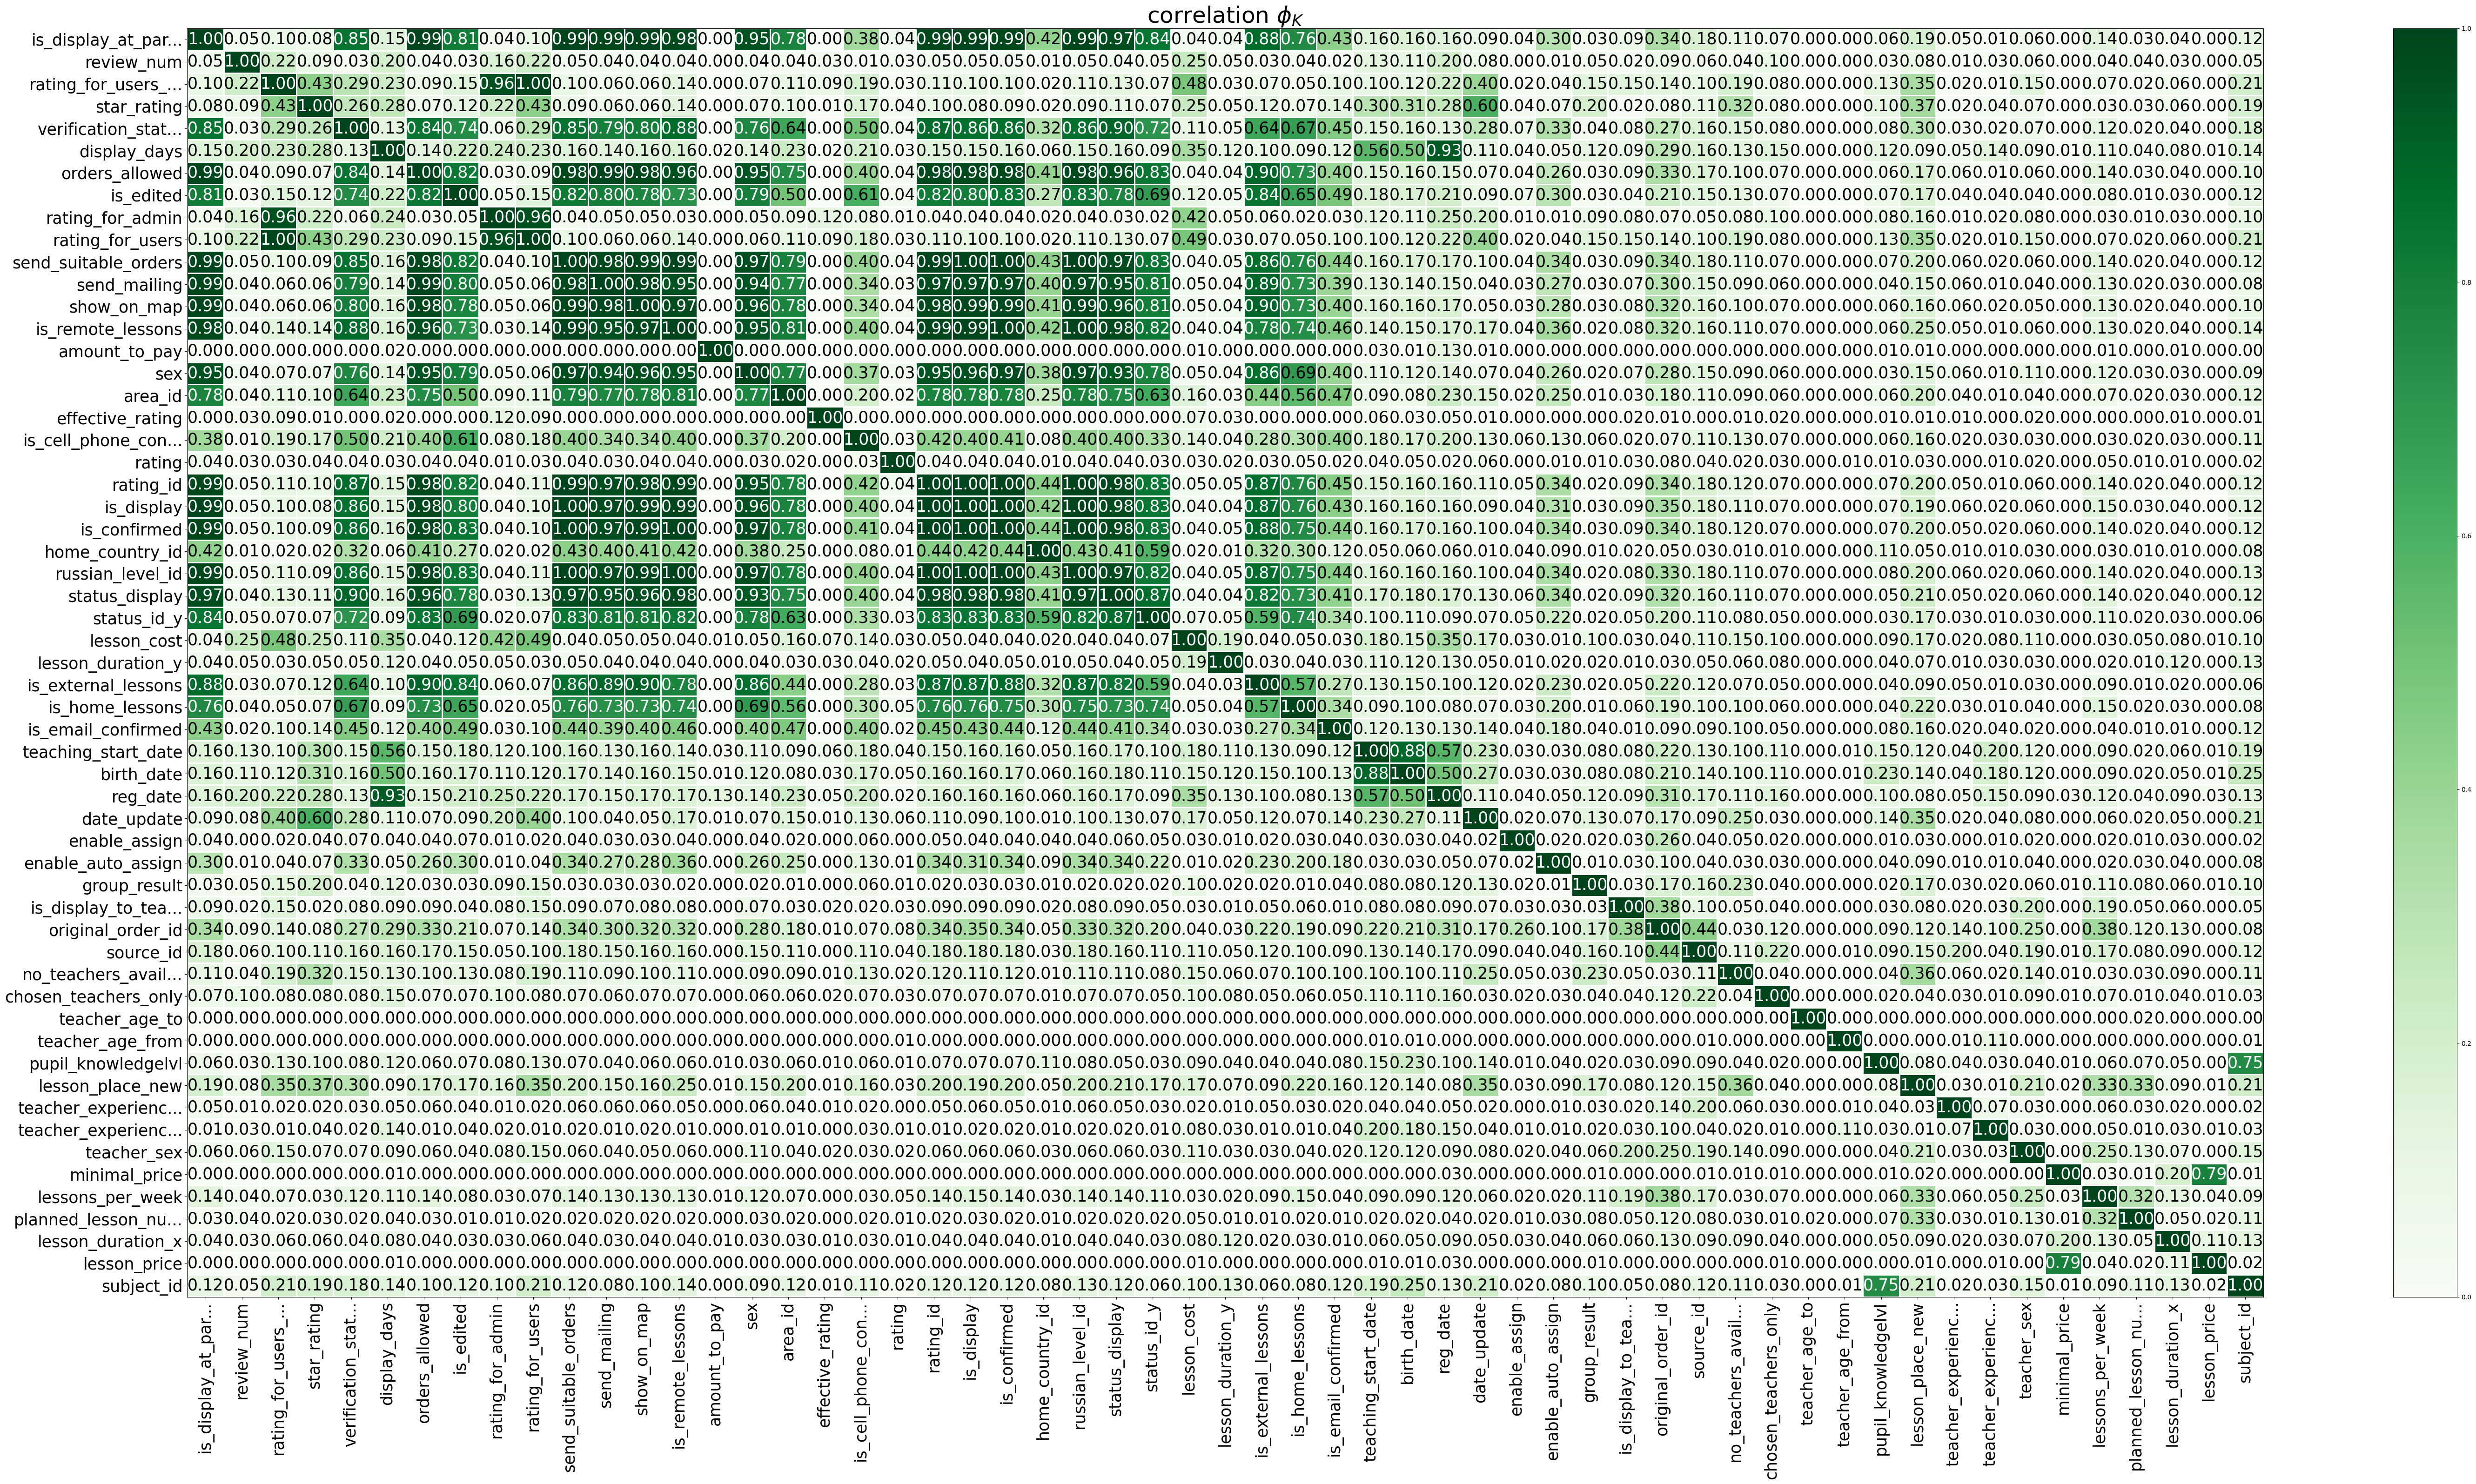

In [39]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=2.5,
                        figsize=(60, 32))
plt.tight_layout()

**Вывод:**

Для датасета df_1 построена матрица фи-корреляции. Наибольшую корреляцию можно наблюдать:
1) У столбца is_display_at_partners со столбцами verification_status_id, orders_allowed, is_edited, send_suitable_orders, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
2) У столбца rating_for_users_yesterday со столбцом rating_for_admin.
3) У столбца verification_status_id со столбцами is_display_at_partners, orders_allowed, is_edited, send_suitable_orders, show_on_map, is_remote_lessons, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons.
4) У столбца display_days со столбцом reg_date.
5) У столбца orders_allowed со столбцами verification_status_id, is_display_at_partners, is_edited, send_suitable_orders, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
6) У столбца is_edited со столбцами is_display_at_partners, orders_allowed, send_suitable_orders, send_mailing, rating_id, is_display, is_confirmed, russian_level_id, is_external_lessons.
7) У столбца rating_for_admin co столбцами rating_for_users_yesterday и rating_for_users.
8) У столбца rating_for_users co столбцами rating_for_users_yesterday и rating_for_admin.
9) У столбца send_suitable_orders со столбцами verification_status_id, orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
10) У столбца send_mailing со столбцами orders_allowed, is_edited, is_display_at_partners, send_suitable_orders, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
11) У столбца show_on_map со столбцами verification_status_id, orders_allowed, is_display_at_partners, send_mailing, send_suitable_orders, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
12) У столбца is_remote_lessons со столбцами verification_status_id, orders_allowed, area_id, is_display_at_partners, send_mailing, show_on_map, send_suitable_orders, sex, rating_id, is_display, is_confirmed, russian_level_id, status_display, status_id_y.
13) У столбца sex со столбцами orders_allowed, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, send_suitable_orders, rating_id, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons.
14) У столбца area_id со столбцом is_remote_lessons.
15) У столбца rating_id со столбцами verification_status_id, orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, send_suitable_orders, is_display, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
16) У столбца is_display со столбцами verification_status_id, orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, send_suitable_orders, is_confirmed, russian_level_id, status_display, is_external_lessons, status_id_y.
17) У столбца is_confirmed со столбцами verification_status_id, orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, send_suitable_orders, russian_level_id, status_display, is_external_lessons, status_id_y.
18) У столбца russian_level_id со столбцами verification_status_id, orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, send_suitable_orders, status_display, is_external_lessons, status_id_y.
19) У столбца status_display со столбцами verification_status_id, orders_allowed, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, sex, rating_id, is_display, is_confirmed, russian_level_id, send_suitable_orders, is_external_lessons, status_id_y.
20) У столбца status_id_y со столбцами orders_allowed, is_display_at_partners, send_mailing, show_on_map, is_remote_lessons, rating_id, is_display, is_confirmed, russian_level_id, send_suitable_orders, status_display.
21) У столбца is_external_lessons со столбцами orders_allowed, is_edited, is_display_at_partners, send_mailing, show_on_map, sex, rating_id, is_display, is_confirmed, russian_level_id, send_suitable_orders, status_display.
22) У столбца teaching_start_date со столбцом birth_date.
23) У столбца reg_date со столбцом display_days.

Пока не будем избавляться от коррелирующих столбцов. Сначала посмотрим, как будут вести себя модели при обучении.

## Подготовка к обучению моделей

### Разобьем датасет на тренировочную и тестовую выборки

In [42]:
df_train, df_test = train_test_split(df_1, test_size=0.25, random_state=18091986)

Выведем информацию о полученных выборках на экран:

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625143 entries, 440868 to 456408
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   subject_id                  625143 non-null  float32
 1   lesson_price                625143 non-null  int32  
 2   lesson_duration_x           625143 non-null  int32  
 3   planned_lesson_number       625143 non-null  int32  
 4   lessons_per_week            625143 non-null  int32  
 5   minimal_price               625143 non-null  int32  
 6   teacher_sex                 625143 non-null  int32  
 7   teacher_experience_from     625143 non-null  int32  
 8   teacher_experience_to       625143 non-null  int32  
 9   lesson_place_new            625143 non-null  int32  
 10  pupil_knowledgelvl          625143 non-null  int32  
 11  teacher_age_from            625143 non-null  int32  
 12  teacher_age_to              625143 non-null  int32  
 13  chosen_teacher

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208381 entries, 682806 to 296220
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   subject_id                  208381 non-null  float32
 1   lesson_price                208381 non-null  int32  
 2   lesson_duration_x           208381 non-null  int32  
 3   planned_lesson_number       208381 non-null  int32  
 4   lessons_per_week            208381 non-null  int32  
 5   minimal_price               208381 non-null  int32  
 6   teacher_sex                 208381 non-null  int32  
 7   teacher_experience_from     208381 non-null  int32  
 8   teacher_experience_to       208381 non-null  int32  
 9   lesson_place_new            208381 non-null  int32  
 10  pupil_knowledgelvl          208381 non-null  int32  
 11  teacher_age_from            208381 non-null  int32  
 12  teacher_age_to              208381 non-null  int32  
 13  chosen_teacher

### Выделим из выборок признаки и целевой признак

In [45]:
target_train = df_train['group_result']
feature_train = df_train.drop(['group_result'], axis=1)

In [46]:
target_test = df_test['group_result']
feature_test = df_test.drop(['group_result'], axis=1)

### Масштабируем числовые признаки

Создадим копии признаков, как предназначенные для использования в модели логистической регрессии (lr) и выведем на экран:

In [54]:
features_train_lr = feature_train.copy()

In [55]:
features_test_lr = feature_test.copy()

In [56]:
features_train_lr.head()

subject_id  lesson_price  lesson_duration_x  planned_lesson_number  \
440868        12.0           900                 60                     10   
67575         19.0           500                 60                     10   
37371         14.0          1500                 60                     10   
434766        36.0          1500                 60                     10   
174725        11.0           900                 60                     10   

        lessons_per_week  minimal_price  teacher_sex  teacher_experience_from  \
440868                 3              0            2                        0   
67575                  3              0            3                        0   
37371                  4              0            2                        5   
434766                 3              0            3                        0   
174725                 5              0            0                        1   

        teacher_experience_to  lesson_place_new  ...  rating_for_users  \
440868                      0                 6  ...       1831.000000   
67575                       0                 2  ...        408.000000   
37371                       0                 1  ...        699.222229   
434766                      0                 1  ...        437.500000   
174725                      0                 6  ...       1220.949951   

        rating_for_admin  is_edited  orders_allowed  display_days  \
440868        962.575012        6.0             9.0        1661.5   
67575         183.375000        0.0             1.0        1476.0   
37371         391.277771        8.0             9.0        2112.0   
434766        122.041664       19.0            30.0        1868.0   
174725        768.299988        0.0            10.0         566.5   

        verification_status_id  star_rating  rating_for_users_yesterday  \
440868                    28.0     4.919531                 1831.199951   
67575                      0.0     5.000000                  408.000000   
37371                     14.0     4.666667                  699.222229   
434766                    37.0     4.463802                  437.950012   
174725                    25.0     4.919922                 1233.949951   

        review_num  is_display_at_partners  
440868        11.0                    10.0  
67575          1.0                     1.0  
37371          1.0                     9.0  
434766         0.0                    30.0  
174725         2.0                    10.0  

[5 rows x 56 columns]

Проведем масштабирование их числовых признаков:

In [59]:
numeric = ['lesson_price', 'lesson_duration_x', 'planned_lesson_number',
           'minimal_price', 'teacher_experience_from', 'teacher_experience_to',
           'rating_for_users', 'rating_for_admin', 'display_days',
           'star_rating', 'rating_for_users_yesterday', 'review_num',
           'teacher_age_from', 'teacher_age_to', 'date_update',
           'reg_date', 'birth_date', 'teaching_start_date',
           'lesson_duration_y', 'lesson_cost', 'rating',
           'effective_rating', 'amount_to_pay']

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

display(features_train_lr.head())

subject_id  lesson_price  lesson_duration_x  planned_lesson_number  \
440868        12.0     -0.199390          -0.108127               0.241906   
67575         19.0     -0.376961          -0.108127               0.241906   
37371         14.0      0.066966          -0.108127               0.241906   
434766        36.0      0.066966          -0.108127               0.241906   
174725        11.0     -0.199390          -0.108127               0.241906   

        lessons_per_week  minimal_price  teacher_sex  teacher_experience_from  \
440868                 3      -0.211714            2                -0.542306   
67575                  3      -0.211714            3                -0.542306   
37371                  4      -0.211714            2                 1.263147   
434766                 3      -0.211714            3                -0.542306   
174725                 5      -0.211714            0                -0.181216   

        teacher_experience_to  lesson_place_new  ...  rating_for_users  \
440868              -0.100313                 6  ...          0.576033   
67575               -0.100313                 2  ...         -0.766772   
37371               -0.100313                 1  ...         -0.491962   
434766              -0.100313                 1  ...         -0.738934   
174725              -0.100313                 6  ...          0.000363   

        rating_for_admin  is_edited  orders_allowed  display_days  \
440868          0.863269        6.0             9.0     -0.059064   
67575          -0.645927        0.0             1.0     -0.325746   
37371          -0.243250        8.0             9.0      0.588590   
434766         -0.764721       19.0            30.0      0.237807   
174725          0.486987        0.0            10.0     -1.633274   

        verification_status_id  star_rating  rating_for_users_yesterday  \
440868                    28.0     0.979652                    0.575151   
67575                      0.0     1.391732                   -0.766807   
37371                     14.0    -0.315268                   -0.492209   
434766                    37.0    -1.354138                   -0.738566   
174725                    25.0     0.981652                    0.011995   

        review_num  is_display_at_partners  
440868    0.331190                    10.0  
67575    -0.562426                     1.0  
37371    -0.562426                     9.0  
434766   -0.651787                    30.0  
174725   -0.473064                    10.0  

[5 rows x 56 columns]

### Вывод:

Произведена разбивка датасета на тренировочную и тестовую выборки. Размер тестовой выборки 25%. Из выборок выделены признаки и целевой признак. Произведено масштабирование числовых признаков.

## Обучение моделей

### LGBM

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма LGBMClassifier:

In [78]:
model = LGBMClassifier(random_state=18091986)
model.fit(feature_train, target_train)

roc_auc = cross_val_score(model, feature_train, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, feature_train, target_train, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

[LightGBM] [Info] Number of positive: 180502, number of negative: 444641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.790021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8011
[LightGBM] [Info] Number of data points in the train set: 625143, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288737 -> initscore=-0.901525
[LightGBM] [Info] Start training from score -0.901525
[LightGBM] [Info] Number of positive: 144402, number of negative: 355712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.629871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8078
[LightGBM] [Info] Number of data points in the train set: 500114, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288738 -> initscore=-0.901520
[LightGBM] [Info] Start training from score -0.901520
[Light

### CatBoost

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма CatBoostClassifier:

In [82]:
model = CatBoostClassifier(random_state=18091986, verbose=False)
model.fit(feature_train, target_train, verbose=False)

roc_auc = cross_val_score(model, feature_train, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, feature_train, target_train, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7216635355882188
Precision модели: 0.5981001064760838


### RandomForest

Зададим диапазон и с помощью GridSearchCV определим оптимальные количество оценщиков и глубину дерева для RandomForestClassifier при наибольшем значении ROC-AUC. Дополнительно определим значение Precision:

In [69]:
parameters = { 'n_estimators': range (1, 10),
              'max_depth': range (1, 10), }

In [70]:
scoring = ['precision', 'roc_auc']

clf = GridSearchCV(RandomForestClassifier(random_state=18091986), parameters, cv=5, scoring=scoring, refit="roc_auc", n_jobs=-1)
clf.fit(feature_train, target_train)

i = clf.best_index_
best_precision = clf.cv_results_['mean_test_precision'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Precision лучшей модели: {}'.format(best_precision))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.6839271861976209
Precision лучшей модели: 0.5963435813931997
Best parametes: {'max_depth': 9, 'n_estimators': 9}


### LogisticRegression

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма Logistic Regression:

In [65]:
model = LogisticRegression(random_state=18091986, solver='liblinear', max_iter=1000)
model.fit(features_train_lr, target_train)

roc_auc = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='precision')

print(f"ROC-AUC: {roc_auc}")
print(f"Precision:\n0: {precision[0]}\n1: {precision[1]}")

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is i

ROC-AUC: 0.583996021169677
Precision:
0: 0.0
1: 0.0


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LGBM с масштабированными признаками

Также, попробуем обучить LGBMClassifier на выборке с масштабированными числовыми признаками:

In [81]:
model = LGBMClassifier(random_state=18091986, verbose= -100)
model.fit(feature_train, target_train)

roc_auc = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7061842054911451
Precision модели: 0.5722888713737092


### Вывод:

Произведено обучение моделей с применением алгоритмов классификации LGBMClassifier, CatBoostClassifier, Случайного Леса с применением GridSearchCV для перебора гиперпараметров, Логистической Регрессии. Также, произведено обучение LGBMClassifier на выборке с масштабированными числовыми признаками.

Наилучшим образом себя показала модель CatBoost с значением ROC-AUC=0.72 и значением precision=0.598

## Борьба с дисбалансом

### Балансировка

#### LGBM

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма LGBMClassifier. Так как количество отрицательных результатов целевого признака примерно в три раза больше количества положительных результатов, для балансировки установим аргумент scale_pos_weight=3:

In [92]:
model = LGBMClassifier(random_state=18091986, verbose= -100, scale_pos_weight=3)
model.fit(feature_train, target_train)

roc_auc = cross_val_score(model, feature_train, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, feature_train, target_train, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7060607306226646
Precision модели: 0.3878835913397972


#### CatBoost

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма CatBoostClassifier с аргументом балансировки, равным 3:

In [91]:
model = CatBoostClassifier(random_state=18091986, verbose=False, scale_pos_weight=3)
model.fit(feature_train, target_train, verbose=False)

roc_auc = cross_val_score(model, feature_train, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, feature_train, target_train, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7213542117778438
Precision модели: 0.40294251705889356


#### RandomForest

Зададим диапазон и с помощью GridSearchCV определим оптимальные количество оценщиков и глубину дерева для RandomForestClassifier при наибольшем значении ROC-AUC. Дополнительно определим значение Precision:

In [88]:
parameters = { 'n_estimators': range (1, 10),
              'max_depth': range (1, 10), }

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма RandomForestClassifier с балансировкой классов:

In [90]:
scoring = ['precision', 'roc_auc']

clf = GridSearchCV(RandomForestClassifier(random_state=18091986, class_weight='balanced'), parameters, cv=5, scoring=scoring, 
                                                                                           refit="roc_auc", n_jobs=-1)
clf.fit(feature_train, target_train)

i = clf.best_index_
best_precision = clf.cv_results_['mean_test_precision'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Precision лучшей модели: {}'.format(best_precision))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.6845077537398533
Precision лучшей модели: 0.39817319990154304
Best parametes: {'max_depth': 9, 'n_estimators': 9}


#### LogisticRegression

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма логистической регрессии с балансировкой классов:

In [87]:
model = LogisticRegression(random_state=18091986, solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(features_train_lr, target_train)

roc_auc = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_train_lr, target_train, cv=5, scoring='precision').mean()

print(f"ROC-AUC: {roc_auc}")
print(f"Precision: {precision}")

ROC-AUC: 0.5971702902003062
Precision: 0.36405753551901665


### Увеличение выборки

Напишем функцию для увеличения выборки:

In [97]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=18091986)

    return features_upsampled, target_upsampled

Произведем увеличение признаков и целевого признака с коэффициентом "3":

In [113]:
features_upsampled, target_upsampled = upsample(feature_train, target_train, 3)

#### LGBM

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма LGBMClassifier на увеличенной выборке:

In [100]:
model = LGBMClassifier(random_state=18091986, verbose=-100)
model.fit(features_upsampled, target_upsampled)

roc_auc = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7091927075345686
Precision модели: 0.6571343514010842


#### CatBoost

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма CatBoostClassifier на увеличенной выборке:

In [101]:
model = CatBoostClassifier(random_state=18091986, verbose=False)
model.fit(features_upsampled, target_upsampled, verbose=False)

roc_auc = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7438298435443362
Precision модели: 0.679157649761482


#### CatBoost с применением GridSearchCV

Зададим диапазон и с помощью GridSearchCV определим оптимальные количество оценщиков и глубину дерева для CatBoostClassifier при наибольшем значении ROC-AUC. Дополнительно определим значение Precision:

In [116]:
parameters = { 'n_estimators': range (1, 10),
              'max_depth': range (1, 10), }

Обучим модель на увеличенной выборке:

In [117]:
scoring = ['precision', 'roc_auc']

clf = GridSearchCV(CatBoostClassifier(random_state=18091986, verbose=False), parameters, cv=5, scoring=scoring, refit="roc_auc", n_jobs=-1)
clf.fit(features_upsampled, target_upsampled)

i = clf.best_index_
best_precision = clf.cv_results_['mean_test_precision'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Precision лучшей модели: {}'.format(best_precision))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.6968165049491887
Precision лучшей модели: 0.6488126360246453
Best parametes: {'max_depth': 9, 'n_estimators': 9}


#### RandomForest

Зададим диапазон и с помощью GridSearchCV определим оптимальные количество оценщиков и глубину дерева для RandomForestClassifier при наибольшем значении ROC-AUC. Обучим модель на увеличенной выборке. Дополнительно определим значение Precision:

In [99]:
scoring = ['precision', 'roc_auc']

clf = GridSearchCV(RandomForestClassifier(random_state=18091986), parameters, cv=5, scoring=scoring, refit="roc_auc", n_jobs=-1)
clf.fit(features_upsampled, target_upsampled)

i = clf.best_index_
best_precision = clf.cv_results_['mean_test_precision'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Precision лучшей модели: {}'.format(best_precision))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.6896484215396704
Precision лучшей модели: 0.6388849705117028
Best parametes: {'max_depth': 9, 'n_estimators': 9}


#### LogisticRegression

Произведем увеличение тренировочной выборки с масштабированными числовыми признаками и целевого признака с коэффициентом "3":

In [102]:
features_upsampled_lr, target_upsampled = upsample(features_train_lr, target_train, 3)

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма логистической регрессии для увеличенной выборки:

In [103]:
model = LogisticRegression(random_state=18091986, solver='liblinear', max_iter=1000)
model.fit(features_upsampled_lr, target_upsampled)

roc_auc = cross_val_score(model, features_upsampled_lr, target_upsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_upsampled_lr, target_upsampled, cv=5, scoring='precision').mean()

print(f"ROC-AUC: {roc_auc}")
print(f"Precision: {precision}")

ROC-AUC: 0.525957053005876
Precision: 0.5491128604561986


### Уменьшение выборки

Напишем функцию для уменьшения выборки:

In [104]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=18091986)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=18091986)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=18091986)

    return features_downsampled, target_downsampled

Произведем уменьшение признаков и целевого признака с коэффициентом "0.33":

In [106]:
features_downsampled, target_downsampled = downsample(feature_train, target_train, 0.33)

#### LGBM

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма LGBMClassifier для уменьшенной выборки:

In [110]:
model = LGBMClassifier(random_state=18091986, verbose=-100)
model.fit(features_downsampled, target_downsampled)

roc_auc = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7048850238691086
Precision модели: 0.6559548360991162


#### CatBoost

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма CatBoostClassifier для уменьшенной выборки:

In [111]:
model = CatBoostClassifier(random_state=18091986, verbose=False)
model.fit(features_downsampled, target_downsampled, verbose=False)

roc_auc = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='precision').mean()

print('ROC-AUC модели:' , roc_auc)
print('Precision модели:' , precision)

ROC-AUC модели: 0.7154503046908577
Precision модели: 0.6632195698603711


#### RandomForest

Зададим диапазон и с помощью GridSearchCV определим оптимальные количество оценщиков и глубину дерева для RandomForestClassifier при наибольшем значении ROC-AUC. Обучим модель на уменьшенной выборке. Дополнительно определим значение Precision:

In [109]:
scoring = ['precision', 'roc_auc']

clf = GridSearchCV(RandomForestClassifier(random_state=18091986), parameters, cv=5, scoring=scoring, refit="roc_auc", n_jobs=-1)
clf.fit(features_downsampled, target_downsampled)

i = clf.best_index_
best_precision = clf.cv_results_['mean_test_precision'][i]

print('ROC-AUC лучшей модели: {}'.format(clf.best_score_))
print('Precision лучшей модели: {}'.format(best_precision))
print('Best parametes: {}'.format(clf.best_params_))

ROC-AUC лучшей модели: 0.6834420365106144
Precision лучшей модели: 0.635369851946529
Best parametes: {'max_depth': 9, 'n_estimators': 9}


#### LogisticRegression

Произведем уменьшение тренировочной выборки с масштабированными числовыми признаками и целевого признака с коэффициентом "0.33":

In [108]:
features_downsampled_lr, target_downsampled = downsample(features_train_lr, target_train, 0.33)

Определим значения ROC-AUC и precision для модели, обученной при помощи алгоритма логистической регрессии для уменьшенной выборки:

In [112]:
model = LogisticRegression(random_state=18091986, solver='liblinear', max_iter=1000)
model.fit(features_downsampled_lr, target_downsampled)

roc_auc = cross_val_score(model, features_downsampled_lr, target_downsampled, cv=5, scoring='roc_auc').mean()
precision = cross_val_score(model, features_downsampled_lr, target_downsampled, cv=5, scoring='precision').mean()

print(f"ROC-AUC: {roc_auc}")
print(f"Precision: {precision}")

ROC-AUC: 0.5226052250147879
Precision: 0.5515991614582554


### Вывод:

Для всех четырех моделей произведено обучение со взвешенными классами (исходя из соотношения 1:3). Также, произведено обучение с увеличенной (для нее также была опробована модель CatBoost с перебором гиперпараметров при помощи GridSearchCV) и уменьшенной выборками. Определены значения ROC-AUC и precision с учетом дисбаланса классов.

Наилучшим образом себя показала модель CatBoostClassifier с увеличенной выборкой. Ее значение ROC-AUC=0.74, а precision=0.679.

## Проверка модели

Проверим модель на тестовой выборке:

In [119]:
model = CatBoostClassifier(random_state=18091986, verbose=False)
model.fit(features_upsampled, target_upsampled, verbose=False)

probabilities_test = model.predict_proba(feature_test)
probabilities_one_test = probabilities_test[:, 1]

predictions_test = model.predict(feature_test)

print('ROC-AUC модели:' , roc_auc_score(target_test, probabilities_one_test))
print('Precision модели:' , precision_score(target_test, predictions_test))

ROC-AUC модели: 0.727423878715206
Precision модели: 0.40804587713962986


**Вывод:**

При проверке модели CatBoostClassifier с увеличенной выборкой на тестовом датасете значение ROC-AUC составило 0.727, а Precision=0.408.

## Общий вывод

1) Произведена загрузка и предварительный анализ трех датасетов. Датасет с информацией о репетиторах, подходящих для конкретной заявки, suitable_teachers и датасет с общей информацией о репетиторах teachers_info содержат столбец с айди репетитора (id и teacher_id, соответственно), по которому осуществлено объединение двух датасетов в датасет teachers.

2) В результате предобработки датасета teachers: Из teachers_info удалены столбцы, задублированные при выгрузке. Пропуски в столбце is_email_confirmed заменены нулем. А пропуски в столбцах is_home_lessons и is_external_lessons заменены единицей. Пропуски в lesson_duration и lesson_cost заменены медианой. Из датасета удалены все строки с пропусками в столбце status_display. Также, удалены столбцы contact_result, external_comments, status_relevant_date, comments, status_school_id, status_college_id, information, is_pupils_needed, pupil_needed_date, remote_comments, passport_id, is_individual, partner_id, status_institution_id, free_time_relevance_date, photo_path, id, teacher_id, user_id, rules_confirmed_date, relevance_date. Они не будут использоваться в дальнейшем обучении моделей. Из столбцов last_visited, date_update, reg_date, birth_date, teaching_start_date удалено время. Они преобразованы в формат datetime64. Последняя дата столбца date_update - 2023-07-11 - принята за дату выгрузки и добавлена в стодбец last_update. Значения столбцов с датами заменены на количество дней, определенное как разницу между датой последнего посещения и самой датой заданного столбца. Затем столбцы last_update и last_visited также удалены из датасета. Датасет teachers сгруппирован по столбцу order_id. Для агрегации значений применена сумма, среднее или медианное значение.

3) В ходе предобработки датасета orders: Из датасета удалены столбцы с данными, неизвестными на момент подачи заявки: start_date, comments, estimated_fee, first_lesson_date, lesson_place, working_teacher_id, additional_status_id, prefered_teacher_id, payment_date, amount_to_pay, add_info, max_metro_distance. Также, удалены строки с ошибочным значением столбца status_id: 3211265, 3342337, 3605505. Датасет проверен на наличие дубликатов. Пропуски в столбце original_order_id заменены соответствующими значениями из столбца id, принятыми за впервые размещенные оригинальные заявки. Сгруппированы повторяющиеся значения столбца original_order_id и всей группе присвоен статус "оплачено". На основе полученных данных создан столбец group_result с целевым признаком.

4) Датасеты orders и teachers объединены по айди заявки (id и order_id, соответственно) в датасет df. В ходе его предобработки: Пропуски в столбце subject_id заполнены значением "8", как самым часто встречающимся. Пропуски в столбце pupil_category_new_id заполнены значением "10", как самым часто встречающимся. В столбце teacher_sex значение "3" заменено на "0", как "пол не указан". Удалены столбцы, которые не будут использоваться при обучении моделей: index, order_date, status_id_x, purpose, home_metro_id, creator_id, pupil_category_new_id, client_id. Из датасета удалены все оставшиеся строки с пропусками.

5) Как результат, создан рабочий датасет, названный df_1: Произведена проверка на наличие дубликатов. Удалены столбцы id и order_id.

6) Для датасета df_1 построена матрица фи-корреляции. Среди многих столбцов наблюдается сильная корреляция.

7) Произведена разбивка датасета на тренировочную и тестовую выборки. Размер тестовой выборки 25%. Из выборок выделены признаки и целевой признак. Произведено масштабирование числовых признаков.

8) Произведено обучение моделей с применением алгоритмов классификации LGBMClassifier, CatBoostClassifier, Случайного Леса с применением GridSearchCV для перебора гиперпараметров, Логистической Регрессии. Также, произведено обучение LGBMClassifier на выборке с масштабированными числовыми признаками. Наилучшим образом себя показала модель CatBoost с значением ROC-AUC=0.72 и значением precision=0.598

9) Для всех четырех моделей произведено обучение со взвешенными классами (исходя из соотношения 1:3). Также, произведено обучение с увеличенной (для нее также была опробована модель CatBoost с перебором гиперпараметров при помощи GridSearchCV) и уменьшенной выборками. Определены значения ROC-AUC и precision с учетом дисбаланса классов. Наилучшим образом себя показала модель CatBoostClassifier с увеличенной выборкой. Ее значение ROC-AUC=0.74, а precision=0.679.

10) При проверке модели CatBoostClassifier с увеличенной выборкой на тестовом датасете значение ROC-AUC составило 0.727, а Precision=0.408.


На данный момент, модель демонстрирует приемлемое значение AUC-ROC, но весьма низкий показатель Precision. Возможны следующие действия по дальнейшему улучшению показателей:
1) Поработать с текстовыми столбцами. Закодировать их, как категориальные признаки.
2) Попробовать сгруппировать числовые столбцы датасета teachers не по сумме, а с использованием метода mode.
3) Создать новый рабочий датасет df_2, не удаляя, а заполнив все пропуски объединенного датасета df.
4) Удалить коррелирующие признаки.